# Forecasting tax avoidance rates by international listed companies

## Problem description

**Tax avoidance is not a crime!** 
Companies that carry out this act are on the verge of law. By definition: tax avoidance consists in carrying out economic activities in such a way that they are understood in a different way from tax regulations, in order to reduce the tax burden. International tax avoidance arose as a result of globalization and liberalization of economic systems of countries, weakening trade barriers and development of new technologies. Tax avoidance is achieved through aggressive **tax optimization** (e.g. tax havens, double taxation agreements, etc.). 

In this study, we will check whether we can **forecast for one year ahead the level of tax avoidance by a group of companies** listed on stock exchanges using shallow Machine Learning models. As the econometric research shows, this problem is non-trivial, and the most important determinants result from the financial statements per se. The question arises whether any additional data sources can be used to forecast this problem. Forecasting such a phenomenon may be particularly important for the tax authorities and legislators. It helps to create rules that would fight against tax avoidance!

There are many ways in the literature to measure tax avoidance. All of them have their advantages and disadvantages. However, the most popular metric appears to be Effective Tax Rate (ETR) = $\dfrac{\textrm{total tax expenses}}{\textrm{pre-tax income}} $. Due to this formula, ETR has values in the range [0,1]. This measure applies directly to each jurisdiction and it is based on annual data published in the financial statements and this involves an annual change in the effective tax rate, or failure to determine it, in the case of negative income tax resulting from current tax overruns of deferred tax assets. ETR will be used as the target/endogenous variable in this study. 

Therefore, the following evaluation metrics for the given problem were selected: Mean Absolute Error (MAE), Root Mean Square error (RMSE). The choice was not accidental: MAE allows for relatively easy interpretation, while RMSE punishes model for large individual errors, which in the case of ETR forecasting may be crucial. For this case, absolute measures seem to be a more correct approach than relative ones. Nevertheless, the most important metric will be RMSE.

This problem is a classic panel problem (many companies and many years).

## Dataset description

The database used in the study was created for the purposes of the paper "Determinants of multinational tax avoidance" (Agnieszka Teterycz, prof. Anna Białek) on the basis of data retrieved from the Bloomberg database, OECD and PWC reports. Information on the introduction of regulations concerning foreign controlled companies (CFCs) in the analysed countries has been selected from OECD reports. From the reports prepared by PWC, data specifying the number of double taxation agreements signed in the analysed countries were selected. The dataset gather companies included in WIG, DAX, UK100, CAC40 and ATX indices listed on stock exchanges in Poland, Germany, Great Britain, France and Austria in 2005-2017. All companies from the financial (including banks) and insurance sectors were excluded from the analysis, as well as those with missing data in the explanatory variables. In addition, the observations that took a negative value for the financial result before tax and income tax were removed in order to avoid situations where a negative value of ETR would be difficult to interpret. The above exclusions and removal of outlier observations reduced the sample for panel data from 7 800 to 4 719 observations. Panel data are balanced (13 years x 363 companies). Inputation process was applied - using medians and means at the company level. Authors also used fill forward interpolation at the beginning of the time series.

#### Columns description 

**Baseline Data**
* index - technical index
* ticker - company ticker from stock exchange
* Nazwa2 - full name of a company
* sektor - business sector of a company
* rok - year
* gielda - the stock exchange from which the company originates {1: Warsaw, 2: London, 3: Frankfurt, 4: Paris, 5: Vienna}
* ta - total assets of a company 
* txt - total tax expenses of a company 
* pi - pre-tax income of a company 
* str - statutory tax rate of a company 
* xrd - research and development expenditure of a company 
* ni - net income of a company 
* ppent - property plant and equipment net of a company  
* intant - total intangible assets of a company 
* dlc - long term debt of a company 
* dltt - short term debt of a company 
* capex - capital expenditures of a company 
* revenue - revenue of a company 
* cce - cash and cash equivalents of a company 
* adv - advertising expenses of a company  
* etr - effective tax rate of a company
* diff - statutory tax rate - effective tax rate
* cfc - control foreign companies by a company [yes/no]
* dta - double taxation agreements [yes/no]

**Created Data - financial transformations on Baseline Data**

* roa - return of assets of a company
* lev - leverage of a company
* intan - intangible assets/total assets
* rd - research and development expenditure/total assets
* ppe - property plant and equipment/total assets
* sale - log(revenue of a company/total assets)
* cash_holdings - cash and cash equivalents of a company/total assets
* adv_expenditures - advertising expenses/total assets
* capex2 - capex/property plant and equipment
* capex2_scaled - scaled capex2

the rest of the columns are technical and redundant, so they will be deleted!

## Dependencies loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pathlib import Path

pd.set_option("display.max_columns", 500)

# np.random.seed(1916) #uncomment if you want your code to be reproducible; for the purposes of our activity, let's add some randomness to the results

## Project setup

In [2]:
raw_input_data_path = "../data/input"
preprocessed_output_data_path = "../data/output"

## Data preparation

Please notice that I will use different ways of data manipulations for tutorial purpose!

### Data loading

In [3]:
df = pd.read_stata(f"{raw_input_data_path}/tax_avoidance.dta")

In [4]:
df.sample(10)

index         Ticker                           Nazwa2  \
1367    725  EGS PW Equity                         Ergis SA   
2691   1494  MNC PW Equity                Mennica Polska SA   
1307    759  ENA PW Equity                          Enea SA   
2054    428  CAR PW Equity                    Inter Cars SA   
3319   1763  PCM PW Equity          Prime Car Management SA   
471    2648  BAS GY Equity                          BASF SE   
1976   1026  IPX PW Equity                    Impexmetal SA   
3247   1809  PHN PW Equity  Polski Holding Nieruchomosci SA   
2413   1291  LCC PW Equity                       LC Corp SA   
284    4330   MT NA Equity                    ArcelorMittal   

                      sektor   rok  gielda            ta          txt  \
1367               materials  2007       1    442.674011     3.014000   
2691  consumer discretionary  2005       1    352.415985    10.384000   
1307               utilities  2012       1  14680.535156   192.442993   
2054  consumer discretionary  2005       1    395.183014     2.114000   
3319             industrials  2009       1   1366.950073    10.879229   
471                materials  2008       2  50860.000000  2671.000000   
1976               materials  2005       1   1815.302002    17.007000   
3247             real estate  2015       1   2514.000000   -72.800003   
2413             real estate  2013       1   2413.947998    10.965000   
284                materials  2016       4  75142.000000   986.000000   

               pi       str     xrd           ni         ppent       intant  \
1367    15.603000  0.190000     0.0    12.102000    171.070999    99.667000   
2691    51.215000  0.190000     0.0    40.831001     67.663002     2.047000   
1307   886.508972  0.190000     0.0   699.672974  10529.746094   201.356995   
2054     2.693000  0.190000     0.0     0.037000     70.153999     2.664000   
3319    46.202961  0.190000     0.0    35.323742    579.931030     0.189171   
471   5976.000000  0.280433  1355.0  2912.000000  15032.000000  9889.000000   
1976    73.389000  0.190000     0.0    60.662998    858.851013    23.127001   
3247   -22.200001  0.190000     0.0    49.099998     45.799999     0.100000   
2413    84.567001  0.190000     0.0    73.601997   1434.661011     0.372000   
284   2720.000000  0.292200   239.0  1779.000000  34831.000000  5651.000000   

               dlc         dltt        capex       revenue          cce  adv  \
1367     97.019997   103.320000    30.820000    426.000000     7.558000  0.0   
2691      3.154000    10.084000    11.022000    499.963013    87.709000  0.0   
1307     55.044998    27.537001  1789.159058  10091.349609  1095.494995  0.0   
2054     12.315000   188.317993    17.955000    749.664001    12.087000  0.0   
3319    404.821381   427.096619     2.480343    373.854553    10.549800  0.0   
471    8290.000000  6224.000000  2521.000000  62304.000000  2776.000000  0.0   
1976     87.144997   490.544006   133.554993   2613.037109    36.341000  0.0   
3247    304.899994     8.100000     0.000000    159.699997   126.500000  0.0   
2413    681.114014   119.547997    98.454002    210.421005   190.319000  0.0   
284   11789.000000  1885.000000  2444.000000  56791.000000  2501.000000  0.0   

           etr      diff       roa       lev     intan        rd       ppe  \
1367  0.193168 -0.003168  0.027338  0.452568  0.225148  0.000000  0.386449   
2691  0.202753 -0.012753  0.115860  0.037564  0.005808  0.000000  0.191998   
1307  0.217080 -0.027080  0.047660  0.005625  0.013716  0.000000  0.717259   
2054  0.784998 -0.594998  0.000094  0.507696  0.006741  0.000000  0.177523   
3319  0.235466 -0.045466  0.025841  0.608594  0.000138  0.000000  0.424252   
471   0.446954 -0.166521  0.057255  0.285372  0.194436  0.026642  0.295556   
1976  0.231738 -0.041738  0.033418  0.318233  0.012740  0.000000  0.473117   
3247  1.000000 -3.089279  0.019531  0.124503  0.000040  0.000000  0.018218   
2413  0.129661  0.060339  0.030490  0.331682  0.000154 

### Dataset adjustment

##### Removing redundant variables

In [5]:
df.columns

Index(['index', 'Ticker', 'Nazwa2', 'sektor', 'rok', 'gielda', 'ta', 'txt',
       'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex',
       'revenue', 'cce', 'adv', 'etr', 'diff', 'roa', 'lev', 'intan', 'rd',
       'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'cfc',
       'dta', 'capex2_scaled', 'firm_id', 'firma_id', 'rok2005', 'rok2006',
       'rok2007', 'rok2008', 'rok2009', 'rok2010', 'rok2011', 'rok2012',
       'rok2013', 'rok2014', 'rok2015', 'rok2016', 'rok2017', 'industry',
       'industry1', 'capex1', 'roa1', 'country1', 'country2', 'country3',
       'country4', 'country5', 'industry11', 'industry12', 'industry13',
       'industry14', 'industry15', 'industry16', 'industry17', 'industry18',
       'industry19', 'industry20', 'diff1', 'diff2', 'diff3', '_est_random',
       '_est_fixed'],
      dtype='object')

In [6]:
df.drop(
    columns=[
        "index",
        "firm_id",
        "firma_id",
        "rok2005",
        "rok2006",
        "rok2007",
        "rok2008",
        "rok2009",
        "rok2010",
        "rok2011",
        "rok2012",
        "rok2013",
        "rok2014",
        "rok2015",
        "rok2016",
        "rok2017",
        "industry",
        "industry1",
        "capex1",
        "roa1",
        "country1",
        "country2",
        "country3",
        "country4",
        "country5",
        "industry11",
        "industry12",
        "industry13",
        "industry14",
        "industry15",
        "industry16",
        "industry17",
        "industry18",
        "industry19",
        "industry20",
        "diff1",
        "diff2",
        "diff3",
        "_est_random",
        "_est_fixed",
    ],
    inplace=True,
)

df.shape

(4719, 33)

In [10]:
df.value_counts("Ticker").to_frame().sort_values("count")

count
Ticker              
AIR FP Equity      6
AIR GY Equity      7
EZJ LN Equity     13
ABE PW Equity     13
ABF LN Equity     13
...              ...
ZEP PW Equity     13
VER AV Equity     13
RMK PW Equity     13
URW NA Equity     13
KTY PW Equity     13

[364 rows x 1 columns]

In [11]:
df.replace({"Ticker": {"AIR GY Equity": "AIR FP Equity"}}, inplace=True)

In [13]:
df.value_counts("Ticker").to_frame()

count
Ticker               
11B PW Equity      13
PLW PW Equity      13
PKN PW Equity      13
PJP PW Equity      13
PHN PW Equity      13
...               ...
FERG LN Equity     13
FEE PW Equity      13
FACC AV Equity     13
EZJ LN Equity      13
ZMT PW Equity      13

[363 rows x 1 columns]

Now our dataset is fully balanced!

##### Checking if every variable has proper type

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4719 entries, 0 to 4718
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ticker           4719 non-null   object 
 1   Nazwa2           4719 non-null   object 
 2   sektor           4719 non-null   object 
 3   rok              4719 non-null   int16  
 4   gielda           4719 non-null   int8   
 5   ta               4719 non-null   float64
 6   txt              4719 non-null   float64
 7   pi               4719 non-null   float64
 8   str              4719 non-null   float64
 9   xrd              4719 non-null   float64
 10  ni               4719 non-null   float64
 11  ppent            4719 non-null   float64
 12  intant           4719 non-null   float64
 13  dlc              4719 non-null   float64
 14  dltt             4719 non-null   float64
 15  capex            4719 non-null   float64
 16  revenue          4719 non-null   float64
 17  cce           

#### Endogenous variable shifting

Now we will create $etr_{t+1}$ target variable. Of course we may reverse shifting and shift only exogenous variables, however for our conviniance let's keep first methodology.

In [15]:
df.sort_values(by=["Ticker", "rok"], inplace=True)

In [16]:
df[["Ticker", "rok", "etr"]].head(20)

Ticker   rok       etr
13   11B PW Equity  2005  0.196193
14   11B PW Equity  2006  0.196193
15   11B PW Equity  2007  0.196193
16   11B PW Equity  2008  0.196193
17   11B PW Equity  2009  0.196193
18   11B PW Equity  2010  0.188487
19   11B PW Equity  2011  0.184468
20   11B PW Equity  2012  0.201958
21   11B PW Equity  2013  0.214825
22   11B PW Equity  2014  0.191744
23   11B PW Equity  2015  0.212176
24   11B PW Equity  2016  0.178090
25   11B PW Equity  2017  0.214678
390  1AT PW Equity  2005  0.133541
391  1AT PW Equity  2006  0.133541
392  1AT PW Equity  2007  0.133541
393  1AT PW Equity  2008  0.133541
394  1AT PW Equity  2009  0.133541
395  1AT PW Equity  2010  0.133541
396  1AT PW Equity  2011  0.133541

In [17]:
df["etr"] = df["etr"].shift(-1)
df = df[df.rok != 2017]
df.shape

(4356, 33)

In [18]:
df[["Ticker", "rok", "etr"]].head(20)

Ticker   rok       etr
13   11B PW Equity  2005  0.196193
14   11B PW Equity  2006  0.196193
15   11B PW Equity  2007  0.196193
16   11B PW Equity  2008  0.196193
17   11B PW Equity  2009  0.188487
18   11B PW Equity  2010  0.184468
19   11B PW Equity  2011  0.201958
20   11B PW Equity  2012  0.214825
21   11B PW Equity  2013  0.191744
22   11B PW Equity  2014  0.212176
23   11B PW Equity  2015  0.178090
24   11B PW Equity  2016  0.214678
390  1AT PW Equity  2005  0.133541
391  1AT PW Equity  2006  0.133541
392  1AT PW Equity  2007  0.133541
393  1AT PW Equity  2008  0.133541
394  1AT PW Equity  2009  0.133541
395  1AT PW Equity  2010  0.133541
396  1AT PW Equity  2011  0.198657
397  1AT PW Equity  2012  0.092764

### External data adding

It was assumed in accordance with the effective market hypothesis that all information about specific companies is included in their book values at the end of the year, i.e. analyzing additional individual stock market data would rather not have the desired effect. In addition, company names (tickers) are not perfect and in some cases it is very difficult to find the right company on websites such as: stooq.pl. Therefore, the bulk approach is not optimal, and manual download would take too much time. Therefore, it was decided to choose variables that will testify to the condition of selected stock exchanges and the entire economy in each country.

**We checked that all added data is available no later than 3 months after the end of a given year. There is no date leakag here !!! The company's financial year should be taken into account, not the calendar year!**

#### First source: World Bank, V-Dem index, Polity index, BR index
We assume that variables like: democracy indices (proxy for investment moods), GDP growth, GDP per capita and Inflation (proxy for business cycle ) might be significant in case of tax avoidance predictions. Data were gathered for mentioned above 5 countries (2005-2017).

In [15]:
df_extra0 = pd.read_csv(
    f"{raw_input_data_path}/external_dataset_part1/external_dataset_part1.csv", sep=";"
)

In [16]:
df_extra0.head()

country_name  year  y_v2x_polyarchy  y_e_p_polity  y_BR_Democracy  \
0      Austria  2005            0.855            10               1   
1      Austria  2006            0.863            10               1   
2      Austria  2007            0.885            10               1   
3      Austria  2008            0.884            10               1   
4      Austria  2009            0.894            10               1   

   WB_GDPgrowth     WB_GDPpc  WB_Inflation  
0      2.244065  38403.13388      2.299139  
1      3.454042  40635.28182      1.441547  
2      3.727415  46855.77175      2.168556  
3      1.460424  51708.76575      3.215950  
4     -3.764578  47963.17940      0.506308

In [17]:
df_extra0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country_name     65 non-null     object 
 1   year             65 non-null     int64  
 2   y_v2x_polyarchy  65 non-null     float64
 3   y_e_p_polity     65 non-null     int64  
 4   y_BR_Democracy   65 non-null     int64  
 5   WB_GDPgrowth     65 non-null     float64
 6   WB_GDPpc         65 non-null     float64
 7   WB_Inflation     65 non-null     float64
dtypes: float64(4), int64(3), object(1)
memory usage: 4.2+ KB


In [18]:
df_extra0.country_name.unique()

array(['Austria', 'France', 'Germany', 'Poland', 'United Kingdom'],
      dtype=object)

In [19]:
df_extra0.country_name = df_extra0.country_name.map(
    {"Poland": 1, "United Kingdom": 2, "Germany": 3, "France": 4, "Austria": 5}
)

In [20]:
df_extra0.country_name.unique()

array([5, 4, 3, 1, 2])

In [21]:
df.shape

(4356, 33)

In [22]:
df = pd.merge(
    df,
    df_extra0,
    left_on=["gielda", "rok"],
    right_on=["country_name", "year"],
    how="left",
)
df.drop(columns=["country_name", "year"], inplace=True)

In [23]:
df.shape

(4356, 39)

#### Second source: main stock market indexes for Poland (WIG), Germany (DAX), Great Britain (FTSE), France (CAC) and Austria (ATX)
We assume that variables like yearly rates of returns might be additional proxy for market condition in each country.

In [24]:
data_per_country_enc_dict = {
    "^cac_y": 4,
    "^dax_y": 3,
    "a5_c_y": 5,
    "wig_y": 1,
    "x_f_y": 2,
}

tmp_list = list()
for i, j in data_per_country_enc_dict.items():
    tmp = pd.read_csv(f"{raw_input_data_path}/external_dataset_part2/{i}.csv").assign(
        country=j
    )
    tmp_list.append(tmp)

tmp_df = (
    pd.concat(tmp_list)
    .assign(
        Date=lambda x: pd.to_datetime(x.Data),
        year=lambda x: x.Date.dt.year,
        rr=lambda x: (x.Zamkniecie - x.Otwarcie) / x.Otwarcie,
    )
    .rename(columns={"rr": "rr_per_country"})[["year", "rr_per_country", "country"]]
)

tmp_df

year  rr_per_country  country
0   2004        0.072338        4
1   2005        0.230944        4
2   2006        0.171144        4
3   2007        0.006874        4
4   2008       -0.426385        4
..   ...             ...      ...
12  2016        0.138159        2
13  2017        0.085869        2
14  2018       -0.128346        2
15  2019        0.120090        2
16  2020       -0.216891        2

[85 rows x 3 columns]

In [25]:
df = pd.merge(
    df, tmp_df, left_on=["rok", "gielda"], right_on=["year", "country"], how="left"
)
df.drop(columns=["year", "country"], inplace=True)

In [26]:
df.shape

(4356, 40)

#### Third source: S&P indexes for sectors
We believe that S&P indexes for sectors might be good proxies for each sector condition during each year!

In [27]:
df.sektor.value_counts()

consumer discretionary    924
industrials               816
materials                 672
technology                444
consumer staples          324
real estate               312
communication             300
health care               228
utilities                 204
energy                    132
Name: sektor, dtype: int64

In [28]:
def data_adjuster(tmp_input, sec):
    # this function is realy messy, so we add some comments

    # create copy of input dataset
    tmp = tmp_input.copy()

    # split the "May 20" column into two separate columns
    foo = tmp["May 20"].str.split(" ", n=1, expand=True)
    tmp["month"] = foo[0]
    tmp["year"] = foo[1]

    # select rows with "Dec" or "Jan" in the "month" column
    tmp = tmp[tmp["month"].isin(["Dec", "Jan"])]

    # convert the "year" column to integer type and remove certain years
    tmp["year"] = ("20" + tmp["year"]).astype(int)
    tmp = tmp[~tmp["year"].isin([2020, 2019, 2018, 2017, 2003])]

    # shift the values in column 2 by 1 row and calculate the "rr" column
    tmp.iloc[:, 2] = tmp.iloc[:, 2].shift(-1)
    tmp["rr"] = (tmp.iloc[:, 1] - tmp.iloc[:, 2]) / tmp.iloc[:, 2]

    # select rows with "Dec" in the "month" column and add the "sector" column
    tmp = tmp[tmp["month"] == "Dec"]
    tmp["sector"] = sec

    # select only the necessary columns and return the resulting dataframe
    return tmp[["sector", "year", "rr"]]

In [29]:
data = [
    ("consumer discretionary", "S&P 500 Consumer Discretionary.xlsx"),
    ("industrials", "S&P 500 Industrial.xlsx"),
    ("materials", "S&P 500 Materials.xlsx"),
    ("technology", "S&P 500 Information Technology.xlsx"),
    ("consumer staples", "S&P 500 Consumer Discretionary.xlsx"),
    ("real estate", "S&P 500 Real Estate.xlsx"),
    ("health care", "S&P 500 Health Care.xlsx"),
    ("utilities", "S&P 500 Utilities.xlsx"),
    ("energy", "S&P 500 Energy.xlsx"),
]

tmp_list = []

for name, file in data:
    tmp = data_adjuster(
        pd.read_excel(
            f"{raw_input_data_path}/external_dataset_part3/{file}",
            dtype={"May 20": str},
        ),
        name,
    )
    tmp_list.append(tmp)

tmp_comm = data_adjuster(
    pd.read_excel(
        f"{raw_input_data_path}/external_dataset_part3/S&P 500.xlsx",
        dtype={"May 20": str},
        thousands=",",
    ),
    "communication",
)
tmp_list.append(tmp_comm)

sp = (
    pd.concat(tmp_list)
    .rename(columns={"rr": "rr_per_sector"})
    .pipe(lambda x: x.loc[x.year != 2004])
    .assign(rr_per_sector=lambda x: x["rr_per_sector"].astype(float))
)

In [30]:
df = pd.merge(
    df, sp, left_on=["rok", "sektor"], right_on=["year", "sector"], how="left"
)
df.drop(columns=["year", "sector"], inplace=True)

In [31]:
df.shape

(4356, 41)

In [32]:
df.head()

Ticker             Nazwa2         sektor   rok  gielda         ta  \
0  11B PW Equity  11 bit studios SA  communication  2005       1  21.127613   
1  11B PW Equity  11 bit studios SA  communication  2006       1  21.127613   
2  11B PW Equity  11 bit studios SA  communication  2007       1  21.127613   
3  11B PW Equity  11 bit studios SA  communication  2008       1  21.127613   
4  11B PW Equity  11 bit studios SA  communication  2009       1  21.127613   

       txt        pi   str  xrd      ni     ppent  intant  dlc  dltt  \
0  1.24185  6.329725  0.19  0.0  5.0879  0.276275  4.1959  0.0   0.0   
1  1.24185  6.329725  0.19  0.0  5.0879  0.276275  4.1959  0.0   0.0   
2  1.24185  6.329725  0.19  0.0  5.0879  0.276275  4.1959  0.0   0.0   
3  1.24185  6.329725  0.19  0.0  5.0879  0.276275  4.1959  0.0   0.0   
4  1.24185  6.329725  0.19  0.0  5.0879  0.276275  4.1959  0.0   0.0   

      capex    revenue        cce  adv       etr      diff       roa  lev  \
0  2.223413  11.873301  12.142975  0.0  0.196193 -0.006193  0.240818  0.0   
1  2.223413  11.873301  12.142975  0.0  0.196193 -0.006193  0.240818  0.0   
2  2.223413  11.873301  12.142975  0.0  0.196193 -0.006193  0.240818  0.0   
3  2.223413  11.873301  12.142975  0.0  0.196193 -0.006193  0.240818  0.0   
4  2.223413  11.873301  12.142975  0.0  0.188487 -0.006193  0.240818  0.0   

      intan   rd       ppe      sale  cash_holdings  adv_expenditure  \
0  0.198598  0.0  0.013076  0.445954       0.574744              0.0   
1  0.198598  0.0  0.013076  0.445954       0.574744              0.0   
2  0.198598  0.0  0.013076  0.445954       0.574744              0.0   
3  0.198598  0.0  0.013076  0.445954       0.574744              0.0   
4  0.198598  0.0  0.013076  0.445954       0.574744              0.0   

     capex2  cfc  dta  capex2_scaled  y_v2x_polyarchy  y_e_p_polity  \
0  8.047824    0    0       0.007469            0.877            10   
1  8.047824    0    0       0.007469            0.884            10   
2  8.047824    0    0       0.007469            0.887            10   
3  8.047824    0    0       0.007469            0.869            10   
4  8.047824    0    0       0.007469            0.878            10   

   y_BR_Democracy  WB_GDPgrowth      WB_GDPpc  WB_Inflation  rr_per_country  \
0               1      3.493668   8021.003655      2.183799        0.334868   
1               1      6.179641   9038.730847      1.284694        0.421396   
2               1      7.034828  11255.436700      2.458743        0.104220   
3               1      4.249609  14001.446880      4.164972       -0.511178   
4               1      2.820260  11527.593230      3.795392        0.429716   

   rr_per_sector  
0       0.030010  
1       0.136194  
2       0.035493  
3      -0.384695  
4       0.234897

### Dataset splitting

We decided to split dataset into:
 * **train (& validation) dataset** - 2005 - 2015 (exogenous notation) x 364 companies
 * **test (out of sample / out of time) dataset**  - 2016 (exogenous notation) x 364 companies 

Test dataset will be used **only** for the final predictions! We assume that during the entire study they do not have access to it and do not study its statistical properties.

In [33]:
df_train = df[df.rok != 2016]
df_test = df[df.rok == 2016]

In [34]:
df_train.shape

(3993, 41)

In [35]:
df_train

Ticker             Nazwa2         sektor   rok  gielda  \
0     11B PW Equity  11 bit studios SA  communication  2005       1   
1     11B PW Equity  11 bit studios SA  communication  2006       1   
2     11B PW Equity  11 bit studios SA  communication  2007       1   
3     11B PW Equity  11 bit studios SA  communication  2008       1   
4     11B PW Equity  11 bit studios SA  communication  2009       1   
...             ...                ...            ...   ...     ...   
4350  ZMT PW Equity  Zamet Industry SA         energy  2011       1   
4351  ZMT PW Equity  Zamet Industry SA         energy  2012       1   
4352  ZMT PW Equity  Zamet Industry SA         energy  2013       1   
4353  ZMT PW Equity  Zamet Industry SA         energy  2014       1   
4354  ZMT PW Equity  Zamet Industry SA         energy  2015       1   

              ta      txt         pi   str  xrd         ni       ppent  \
0      21.127613  1.24185   6.329725  0.19  0.0   5.087900    0.276275   
1      21.127613  1.24185   6.329725  0.19  0.0   5.087900    0.276275   
2      21.127613  1.24185   6.329725  0.19  0.0   5.087900    0.276275   
3      21.127613  1.24185   6.329725  0.19  0.0   5.087900    0.276275   
4      21.127613  1.24185   6.329725  0.19  0.0   5.087900    0.276275   
...          ...      ...        ...   ...  ...        ...         ...   
4350  203.889008  7.99200  32.415001  0.19  0.0  24.423000   75.615997   
4351  176.524002  7.32400  36.959999  0.19  0.0  29.636000   71.445000   
4352  218.889008  7.08800  36.972000  0.19  0.0  29.884001   71.052002   
4353  264.322998  4.07900  29.132000  0.19  0.0  25.052999  115.347000   
4354  265.816010  3.33400  17.288000  0.19  0.0  13.954000  111.014999   

         intant     dlc       dltt     capex     revenue        cce  adv  \
0      4.195900   0.000   0.000000  2.223413   11.873301  12.142975  0.0   
1      4.195900   0.000   0.000000  2.223413   11.873301  12.142975  0.0   
2      4.195900   0.000   0.000000  2.223413   11.873301  12.142975  0.0   
3      4.195900   0.000   0.000000  2.223413   11.873301  12.142975  0.0   
4      4.195900   0.000   0.000000  2.223413   11.873301  12.142975  0.0   
...         ...     ...        ...       ...         ...        ...  ...   
4350  15.854000   4.079  22.944000  1.602000  163.755005  24.014999  0.0   
4351  15.908000   0.110  14.228000  1.792000  169.585007   9.774000  0.0   
4352  16.475000   0.110  38.247002  6.310000  186.781998   2.325000  0.0   
4353  17.138000  11.943  22.947001  6.750000  217.199005   3.462000  0.0   
4354  16.756001   6.787  33.549000  4.256000  205.934006   0.711000  0.0   

           etr      diff       roa       lev     intan   rd       ppe  \
0     0.196193 -0.006193  0.240818  0.000000  0.198598  0.0  0.013076   
1     0.196193 -0.006193  0.240818  0.000000  0.198598  0.0  0.013076   
2     0.196193 -0.006193  0.240818  0.000000  0.198598  0.0  0.013076   
3     0.196193 -0.006193  0.240818  0.000000  0.198598  0.0  0.013076   
4     0.188487 -0.006193  0.240818  0.000000  0.198598  0.0  0.013076   
...        ...       ...       ...       ...       ...  ...       ...   
4350  0.198160 -0.056553  0.119786  0.132538  0.077758  0.0  0.370868   
4351  0.191713 -0.008160  0.167887  0.081224  0.090118  0.0  0.404732   
4352  0.140018 -0.001713  0.136526  0.175235  0.075266  0.0  0.324603   
4353  0.192851  0.049982  0.094782  0.131998  0.064837  0.0  0.436387   
4354  0.204846 -0.002851  0.052495  0.151744  0.063036  0.0  0.417638   

          sale  cash_holdings  adv_expenditure    capex2  cfc  dta  \
0     0.445954       0.574744              0.0  8.047824    0    0   
1     0.445954       0.574744              0.0  8.047824    0    0   
2     0.445954       0.574744              0.0  8.047824    0    0   
3     0.445954       0.574744              0.0  8.047824    0    0   
4     0.445954       0.574744              0.0  8.047824    0    0   
...        ...            ...              ...       ...  ...

In [36]:
df_test.shape

(363, 41)

In [37]:
Path(preprocessed_output_data_path).mkdir(parents=True, exist_ok=True)

In [38]:
df_train.to_csv(f"{preprocessed_output_data_path}/train.csv")
df_test.to_csv(f"{preprocessed_output_data_path}/test.csv")

In [39]:
df = df_train

## Initial descriptive analyses of the data

In [40]:
df.shape

(3993, 41)

In [41]:
df.head()

Ticker             Nazwa2         sektor   rok  gielda         ta  \
0  11B PW Equity  11 bit studios SA  communication  2005       1  21.127613   
1  11B PW Equity  11 bit studios SA  communication  2006       1  21.127613   
2  11B PW Equity  11 bit studios SA  communication  2007       1  21.127613   
3  11B PW Equity  11 bit studios SA  communication  2008       1  21.127613   
4  11B PW Equity  11 bit studios SA  communication  2009       1  21.127613   

       txt        pi   str  xrd      ni     ppent  intant  dlc  dltt  \
0  1.24185  6.329725  0.19  0.0  5.0879  0.276275  4.1959  0.0   0.0   
1  1.24185  6.329725  0.19  0.0  5.0879  0.276275  4.1959  0.0   0.0   
2  1.24185  6.329725  0.19  0.0  5.0879  0.276275  4.1959  0.0   0.0   
3  1.24185  6.329725  0.19  0.0  5.0879  0.276275  4.1959  0.0   0.0   
4  1.24185  6.329725  0.19  0.0  5.0879  0.276275  4.1959  0.0   0.0   

      capex    revenue        cce  adv       etr      diff       roa  lev  \
0  2.223413  11.873301  12.142975  0.0  0.196193 -0.006193  0.240818  0.0   
1  2.223413  11.873301  12.142975  0.0  0.196193 -0.006193  0.240818  0.0   
2  2.223413  11.873301  12.142975  0.0  0.196193 -0.006193  0.240818  0.0   
3  2.223413  11.873301  12.142975  0.0  0.196193 -0.006193  0.240818  0.0   
4  2.223413  11.873301  12.142975  0.0  0.188487 -0.006193  0.240818  0.0   

      intan   rd       ppe      sale  cash_holdings  adv_expenditure  \
0  0.198598  0.0  0.013076  0.445954       0.574744              0.0   
1  0.198598  0.0  0.013076  0.445954       0.574744              0.0   
2  0.198598  0.0  0.013076  0.445954       0.574744              0.0   
3  0.198598  0.0  0.013076  0.445954       0.574744              0.0   
4  0.198598  0.0  0.013076  0.445954       0.574744              0.0   

     capex2  cfc  dta  capex2_scaled  y_v2x_polyarchy  y_e_p_polity  \
0  8.047824    0    0       0.007469            0.877            10   
1  8.047824    0    0       0.007469            0.884            10   
2  8.047824    0    0       0.007469            0.887            10   
3  8.047824    0    0       0.007469            0.869            10   
4  8.047824    0    0       0.007469            0.878            10   

   y_BR_Democracy  WB_GDPgrowth      WB_GDPpc  WB_Inflation  rr_per_country  \
0               1      3.493668   8021.003655      2.183799        0.334868   
1               1      6.179641   9038.730847      1.284694        0.421396   
2               1      7.034828  11255.436700      2.458743        0.104220   
3               1      4.249609  14001.446880      4.164972       -0.511178   
4               1      2.820260  11527.593230      3.795392        0.429716   

   rr_per_sector  
0       0.030010  
1       0.136194  
2       0.035493  
3      -0.384695  
4       0.234897

### Imputation
As we can see we don't have missings in our variables. This is due to the fact that our main data set was already prepared for econometric analysis (which is at the stage of publication), so that imputations (moving averages and other local interpolations within each company) have already been imposed on it. In addition, additional data sets are based on stock market data, which is complete for such important indexes. Other data such as GDP, Inflation and democratization indicators are also complete for such developed countries as Poland, UK, Germany, Austria and France.

In [42]:
df.isna().sum()

Ticker             0
Nazwa2             0
sektor             0
rok                0
gielda             0
ta                 0
txt                0
pi                 0
str                0
xrd                0
ni                 0
ppent              0
intant             0
dlc                0
dltt               0
capex              0
revenue            0
cce                0
adv                0
etr                0
diff               0
roa                0
lev                0
intan              0
rd                 0
ppe                0
sale               0
cash_holdings      0
adv_expenditure    0
capex2             0
cfc                0
dta                0
capex2_scaled      0
y_v2x_polyarchy    0
y_e_p_polity       0
y_BR_Democracy     0
WB_GDPgrowth       0
WB_GDPpc           0
WB_Inflation       0
rr_per_country     0
rr_per_sector      0
dtype: int64

### Target variable analysis

According to the formula, the higher the ETR value, the less companies are avoiding taxation. The relationship is negative! The relationship is negative!

#### General view over time

*****Measures of central tendency: mean, mode, median, quartiles*****

Based on them we can see that data points are concentrated in the range [0-0.34]!

In [43]:
df.etr.mean()

0.21503377452203856

In [44]:
df.etr.median()

0.2050852271478223

In [45]:
df.etr.mode()

0    0.0
Name: etr, dtype: float64

In [46]:
[{i: df.etr.quantile(i)} for i in np.arange(0, 1.1, 0.1)]

[{0.0: 0.0},
 {0.1: 2.7449906077080377e-05},
 {0.2: 0.11328259709214938},
 {0.30000000000000004: 0.16593047912311285},
 {0.4: 0.19265164026114487},
 {0.5: 0.2050852271478223},
 {0.6000000000000001: 0.22654637451112455},
 {0.7000000000000001: 0.25686299708073973},
 {0.8: 0.29092447554799344},
 {0.9: 0.34324424506798284},
 {1.0: 1.0}]

*****Measures of dispersion: standard deviation, IQR*****

We can see that std. deviation and IQR are quite small.

In [47]:
df.etr.var()

0.023705452264696277

In [48]:
df.etr.std()

0.15396575029757845

In [49]:
df.etr.quantile(0.75) - df.etr.quantile(0.25)

0.13494330566561988

*****Measures of shape: Skewness, Kurtosis*****

Distribution is clearly right skewed and leptokurtic!

In [50]:
df.etr.skew()

2.0179560672907657

In [51]:
df.etr.kurtosis()

8.326648946832979

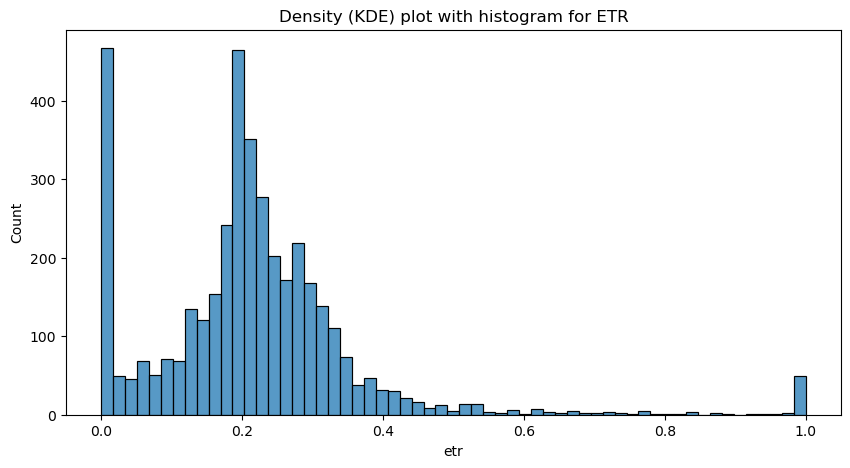

In [52]:
plt.figure(figsize=(10, 5))
sns.histplot(df.etr).set(title="Density (KDE) plot with histogram for ETR")
plt.show()

#### Distribution in each year

As we can see distribution of the ETR is quite constant across the time. We can see that one period before crises (2008) tax avoidance increased and remained stable for several years! Interestingly, in the same period (2008) the number of "honest" companies increased (significantly more companies with the value of 1 ETR).

In [53]:
df.groupby("rok")["etr"].describe()

count      mean       std  min       25%       50%       75%  max
rok                                                                    
2005  363.0  0.223732  0.136084  0.0  0.163922  0.209336  0.279642  1.0
2006  363.0  0.219785  0.139581  0.0  0.160549  0.205245  0.279419  1.0
2007  363.0  0.221698  0.160034  0.0  0.148167  0.208185  0.289624  1.0
2008  363.0  0.228135  0.195130  0.0  0.124350  0.200321  0.282661  1.0
2009  363.0  0.207868  0.138450  0.0  0.144386  0.204454  0.270676  1.0
2010  363.0  0.202139  0.144413  0.0  0.127629  0.204454  0.273531  1.0
2011  363.0  0.209109  0.157153  0.0  0.139700  0.204259  0.274375  1.0
2012  363.0  0.220537  0.153659  0.0  0.143650  0.207470  0.278924  1.0
2013  363.0  0.206929  0.142670  0.0  0.138534  0.208067  0.268008  1.0
2014  363.0  0.203647  0.145515  0.0  0.130951  0.201166  0.268914  1.0
2015  363.0  0.221791  0.170366  0.0  0.146561  0.205734  0.267758  1.0

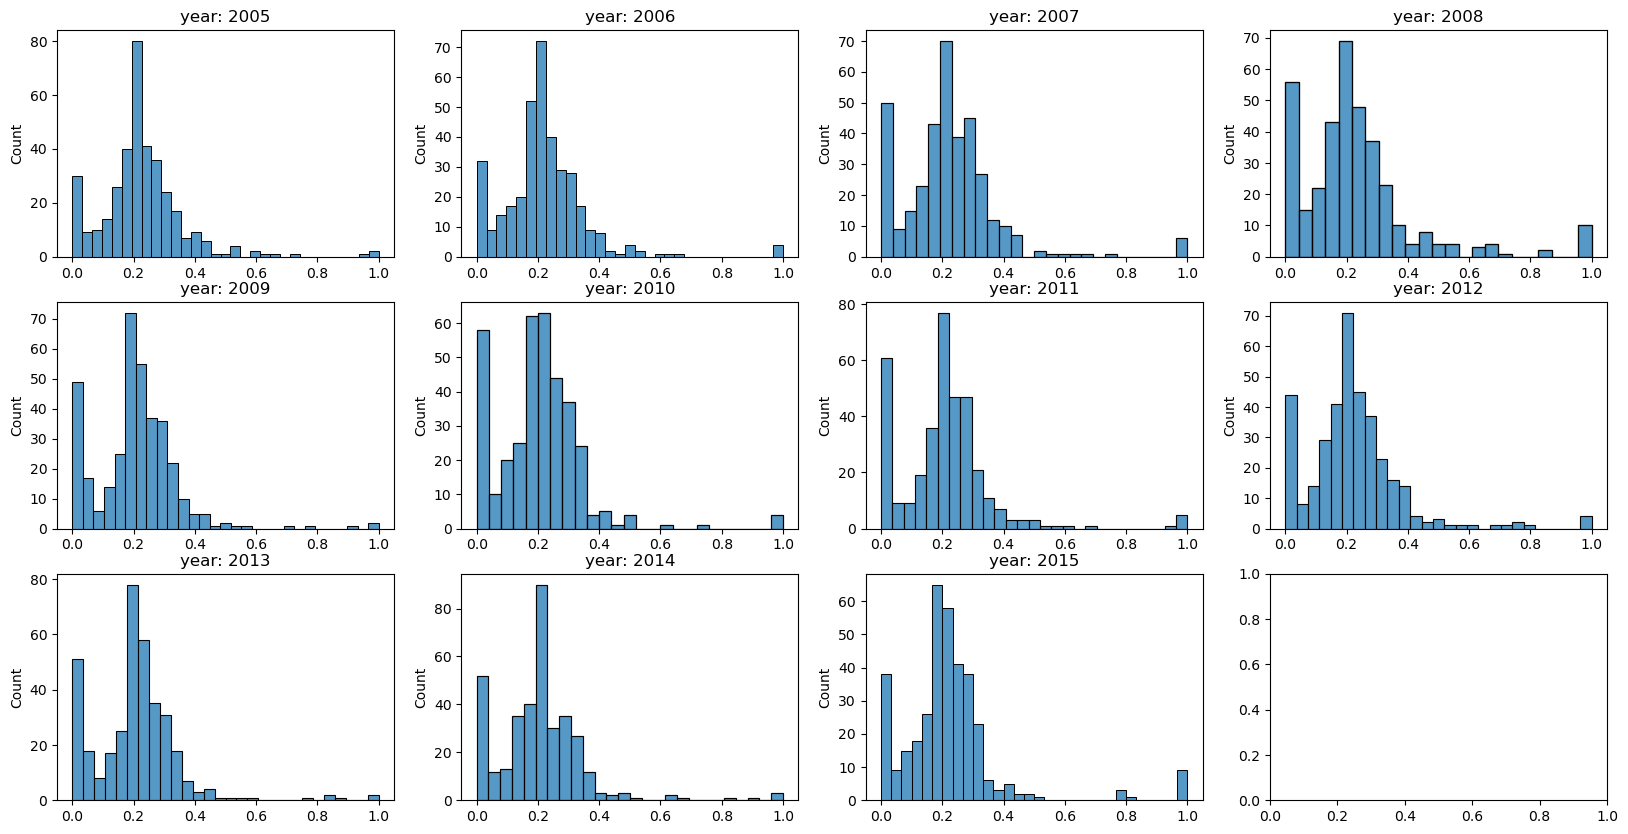

In [54]:
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(20, 10))
for i, ax in zip(range(2005, 2016), axes.flat):
    sns.histplot(df[df.rok == i].etr, ax=ax).set(title=f"year: {i}", xlabel="")
plt.show()

Quantiles keep more or less the same values. Except during the crisis period as mentioned earlier. Outliers, as mentioned earlier, are particularly numerous in 2008. The visible impact of the business cycle!

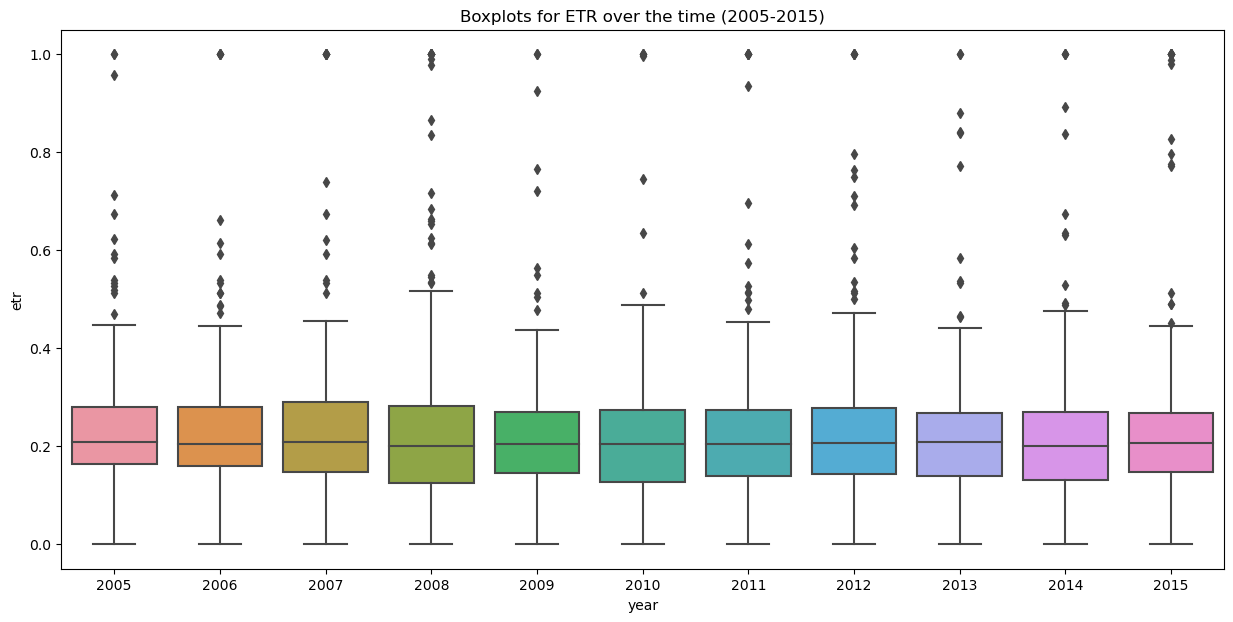

In [55]:
plt.figure(figsize=(15, 7))
sns.boxplot(x=df.rok, y=df.etr).set(title="Boxplots for ETR over the time (2005-2015)")
plt.xlabel("year")
plt.show()

#### Distribution across countries overtime

1: Warsaw, 2: London, 3: Frankfurt, 4: Paris, 5: Vienna

Based on such plots we can claim that Polish companies like to avoid taxation. The most "honest" group of companies comes from France and London. BUT! This may also be due to the fact that there are differences in the accounting policy between countries, and in addition ETR does not catch situations such as the company has a subsidiary in a tax haven.

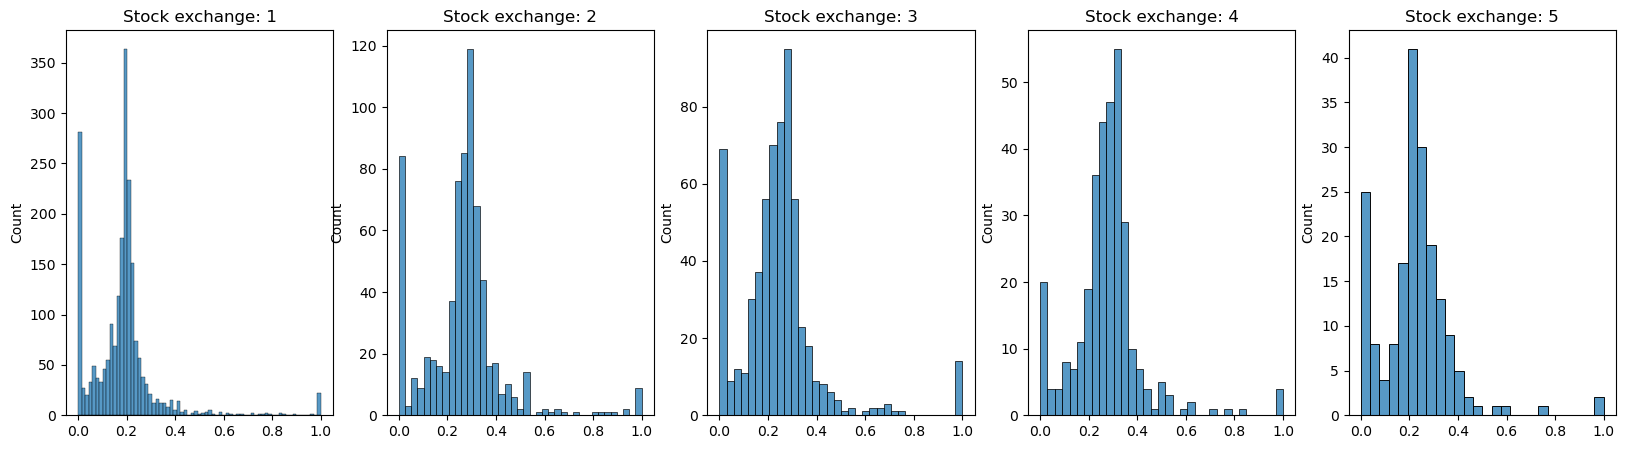

In [56]:
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(20, 5))
for i, ax in zip(range(1, 6), axes.flat):
    sns.histplot(df[df.gielda == i].etr, ax=ax).set(
        title=f"Stock exchange: {i}", xlabel=""
    )
plt.show()

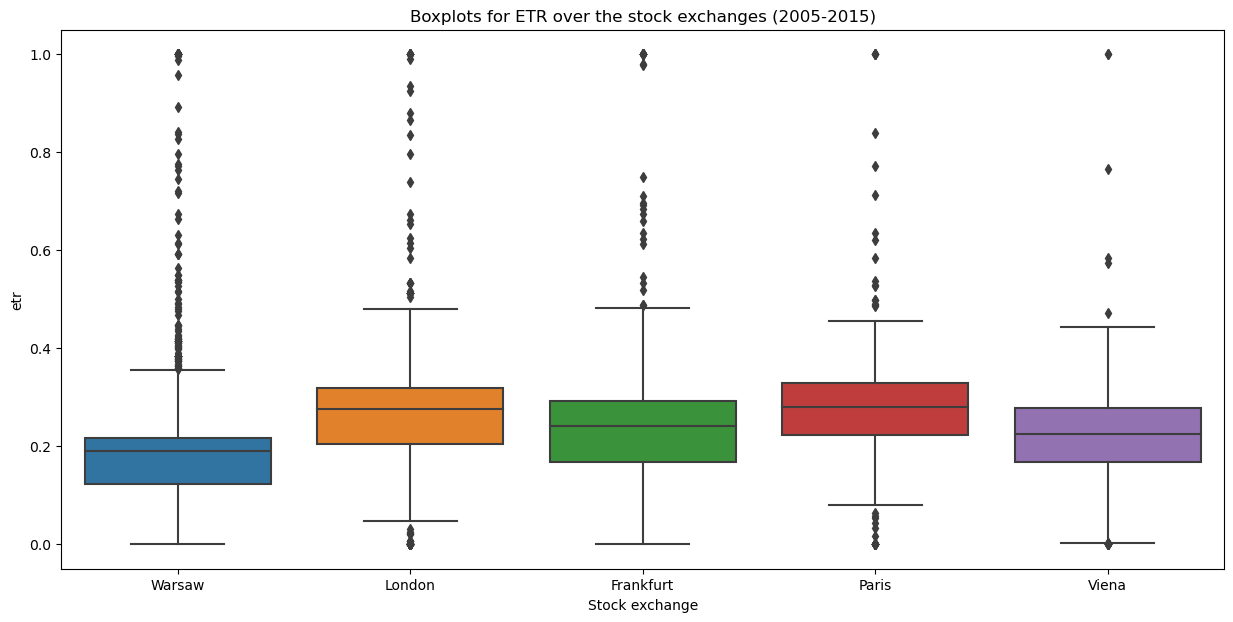

In [57]:
plt.figure(figsize=(15, 7))
sns.boxplot(x=df.gielda, y=df.etr).set(
    title="Boxplots for ETR over the stock exchanges (2005-2015)",
    xlabel="Stock exchange",
)
plt.xticks(range(5), ["Warsaw", "London", "Frankfurt", "Paris", "Viena"])
plt.show()

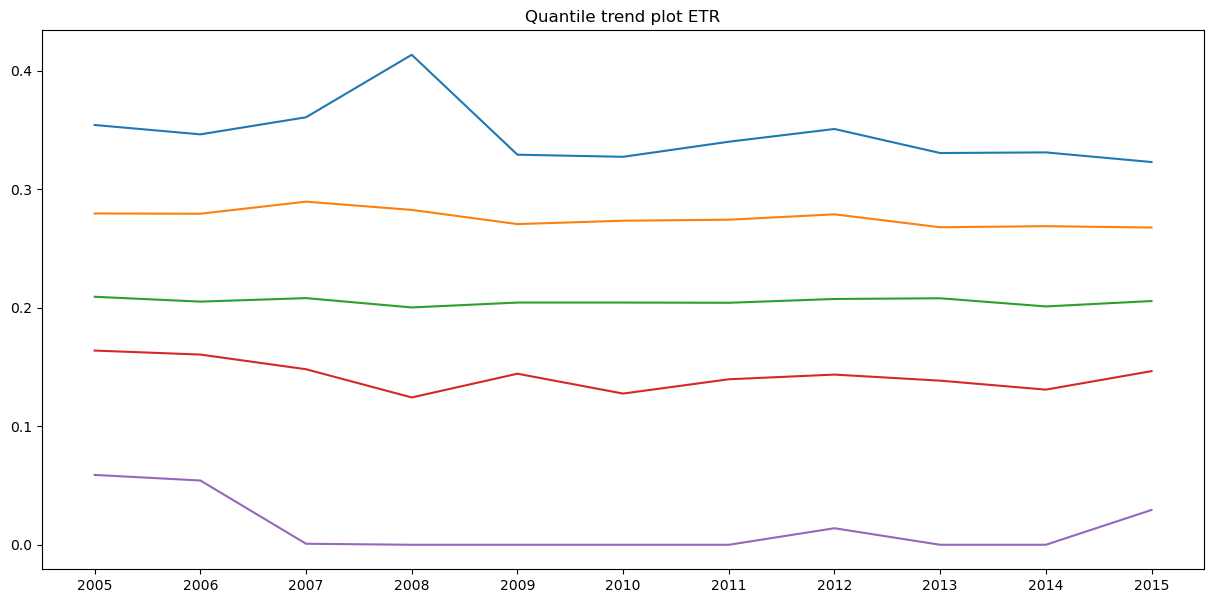

In [58]:
quantile_trend_graph = df.groupby("rok")["etr"].describe(
    percentiles=[0.25, 0.5, 0.75, 0.10, 0.90]
)

plt.figure(figsize=(15, 7))
for quantile in ["90%", "75%", "50%", "25%", "10%"]:
    plt.plot(quantile_trend_graph.index, quantile_trend_graph[quantile])
plt.title("Quantile trend plot ETR")
plt.xticks(range(2005, 2016))
plt.show()

#### Distribution across sectors over time

In [59]:
df.sektor.nunique()

10

Here we can see that real estate sector likes tax avoidance very much.  

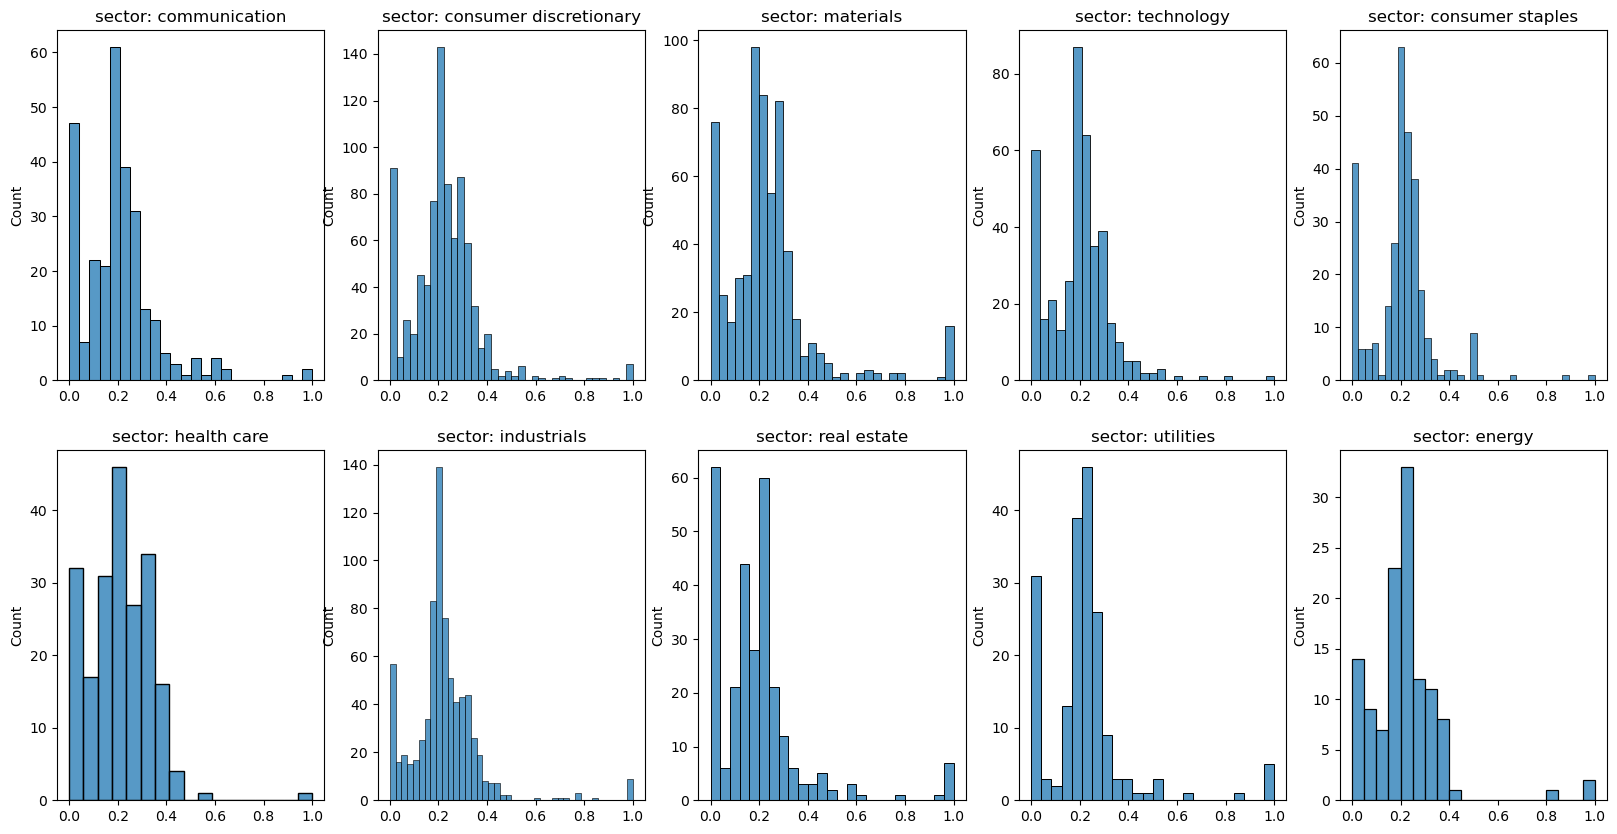

In [60]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
for i, ax in zip(df.sektor.unique(), axes.flat):
    sns.histplot(df[df.sektor == i].etr, ax=ax).set(title=f"sector: {i}", xlabel="")
plt.show()

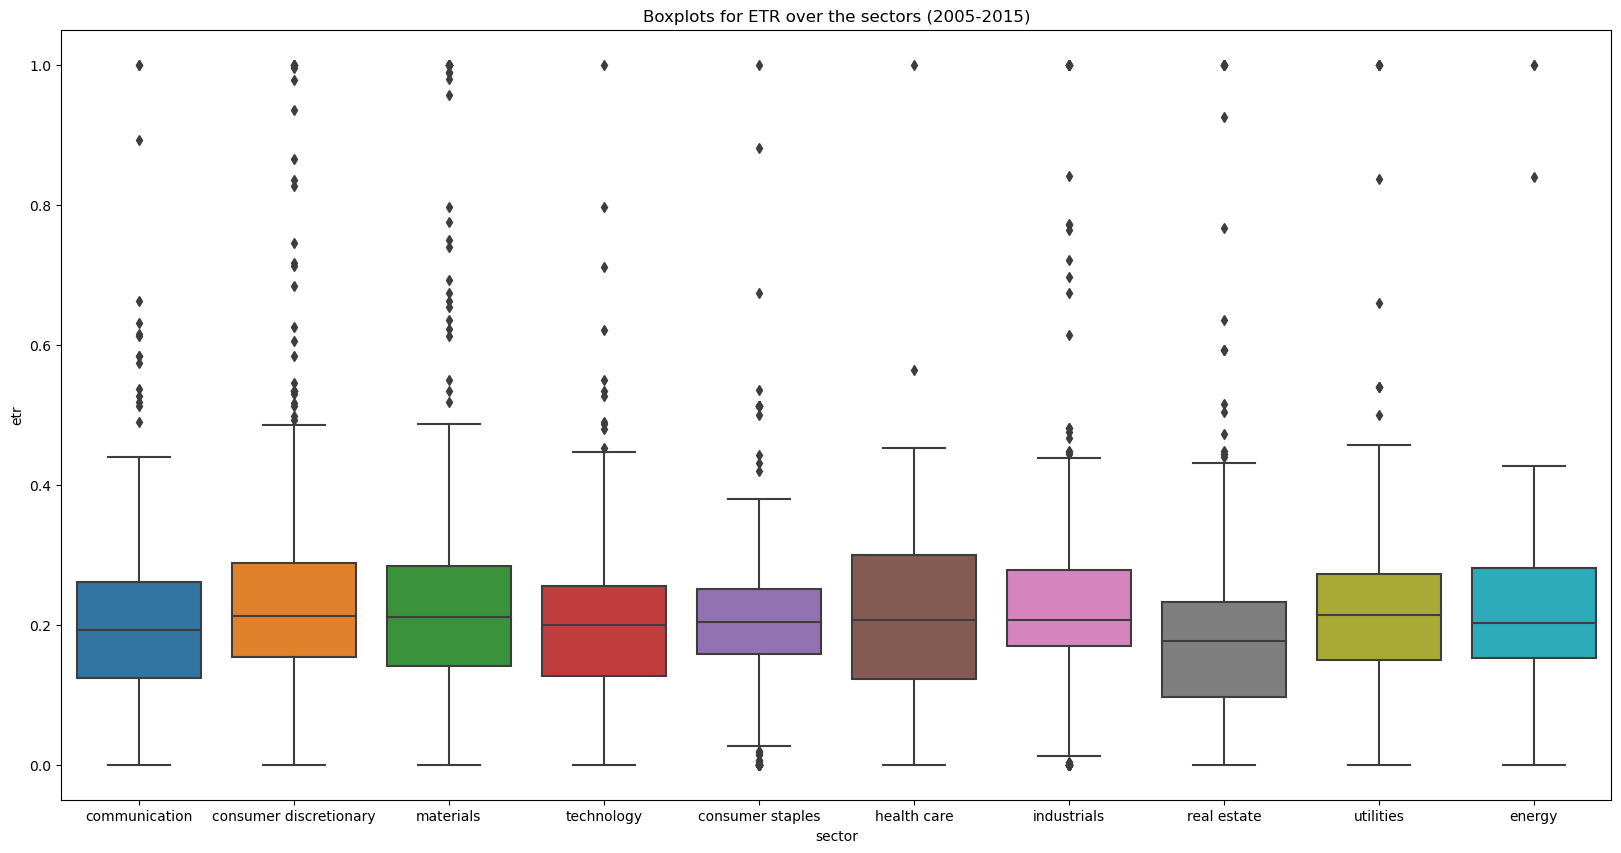

In [61]:
plt.figure(figsize=(20, 10))
sns.boxplot(x=df.sektor, y=df.etr).set(
    title="Boxplots for ETR over the sectors (2005-2015)", xlabel="sector"
)
plt.show()

#### Gathered all above analysis into one plot

Ok it is bad idea in such a case (too many levels). But we can clearly confirm some previous conclusions.

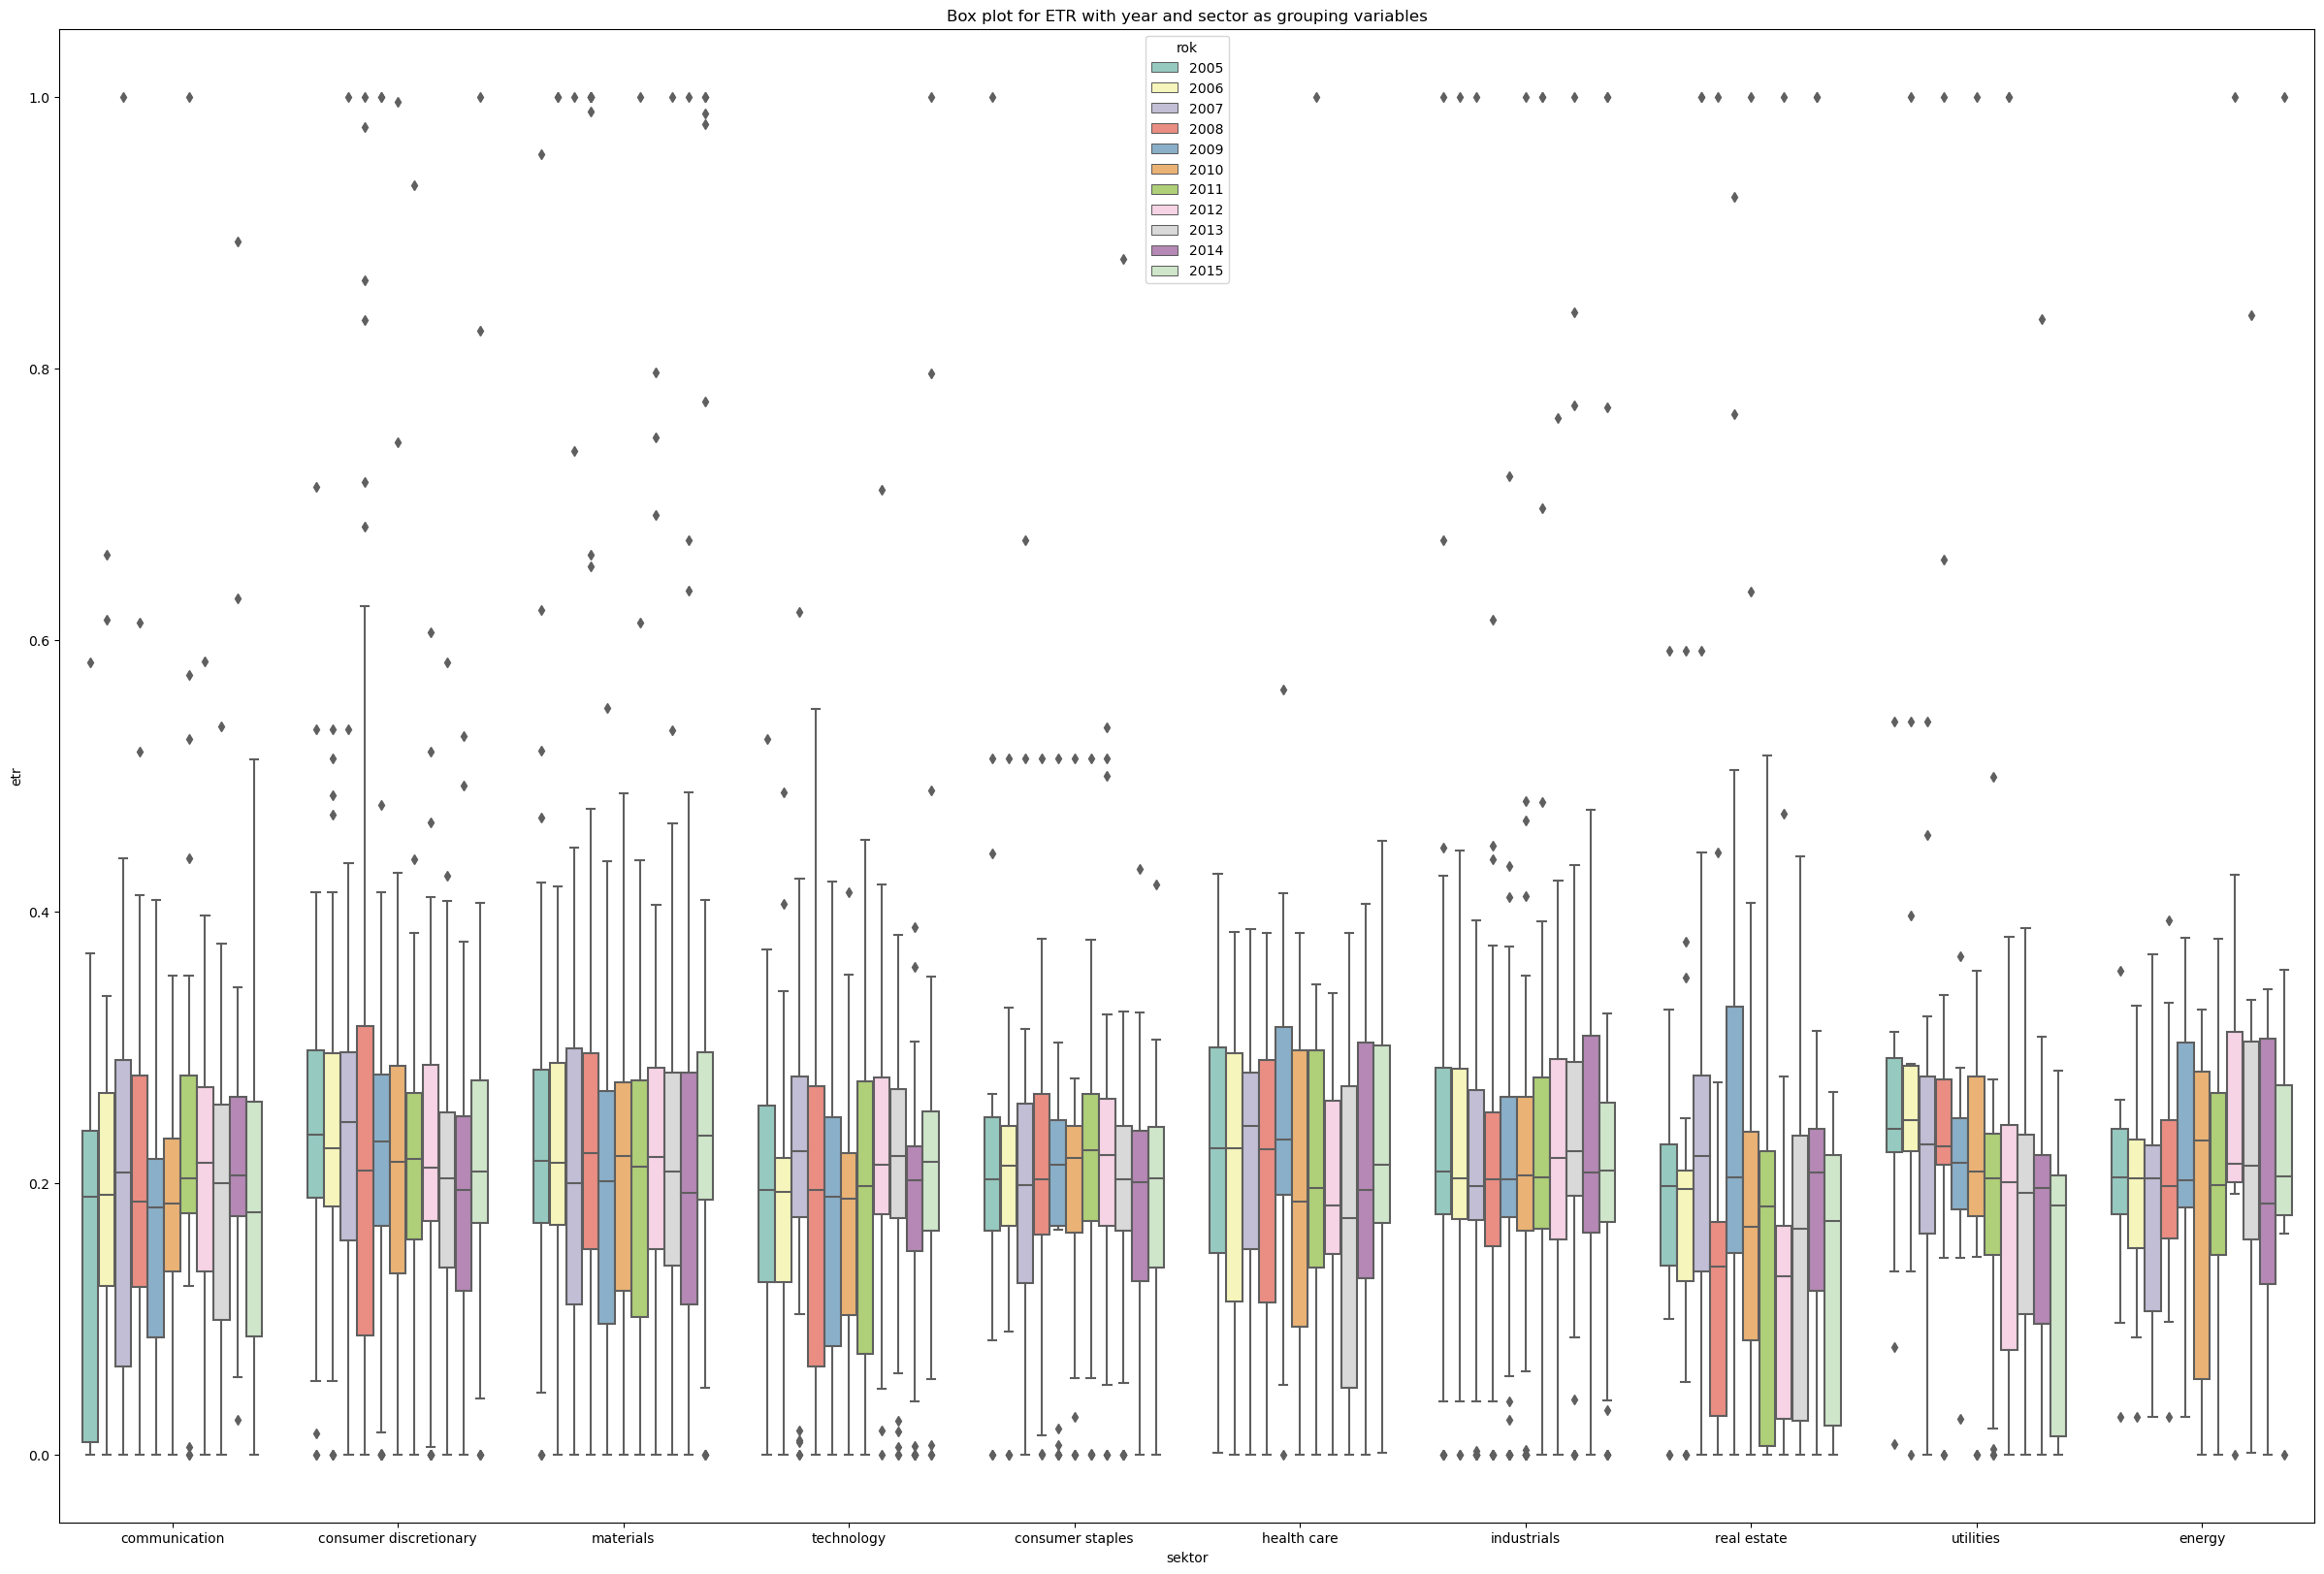

In [62]:
plt.figure(figsize=(30, 20))
sns.boxplot(x="sektor", y="etr", hue="rok", data=df, palette="Set3").set(
    title="Box plot for ETR with year and sector as grouping variables"
)
plt.show()

/Users/michalwozniak/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 5.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/michalwozniak/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 6.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/michalwozniak/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/michalwozniak/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/michalwozniak/opt/ana

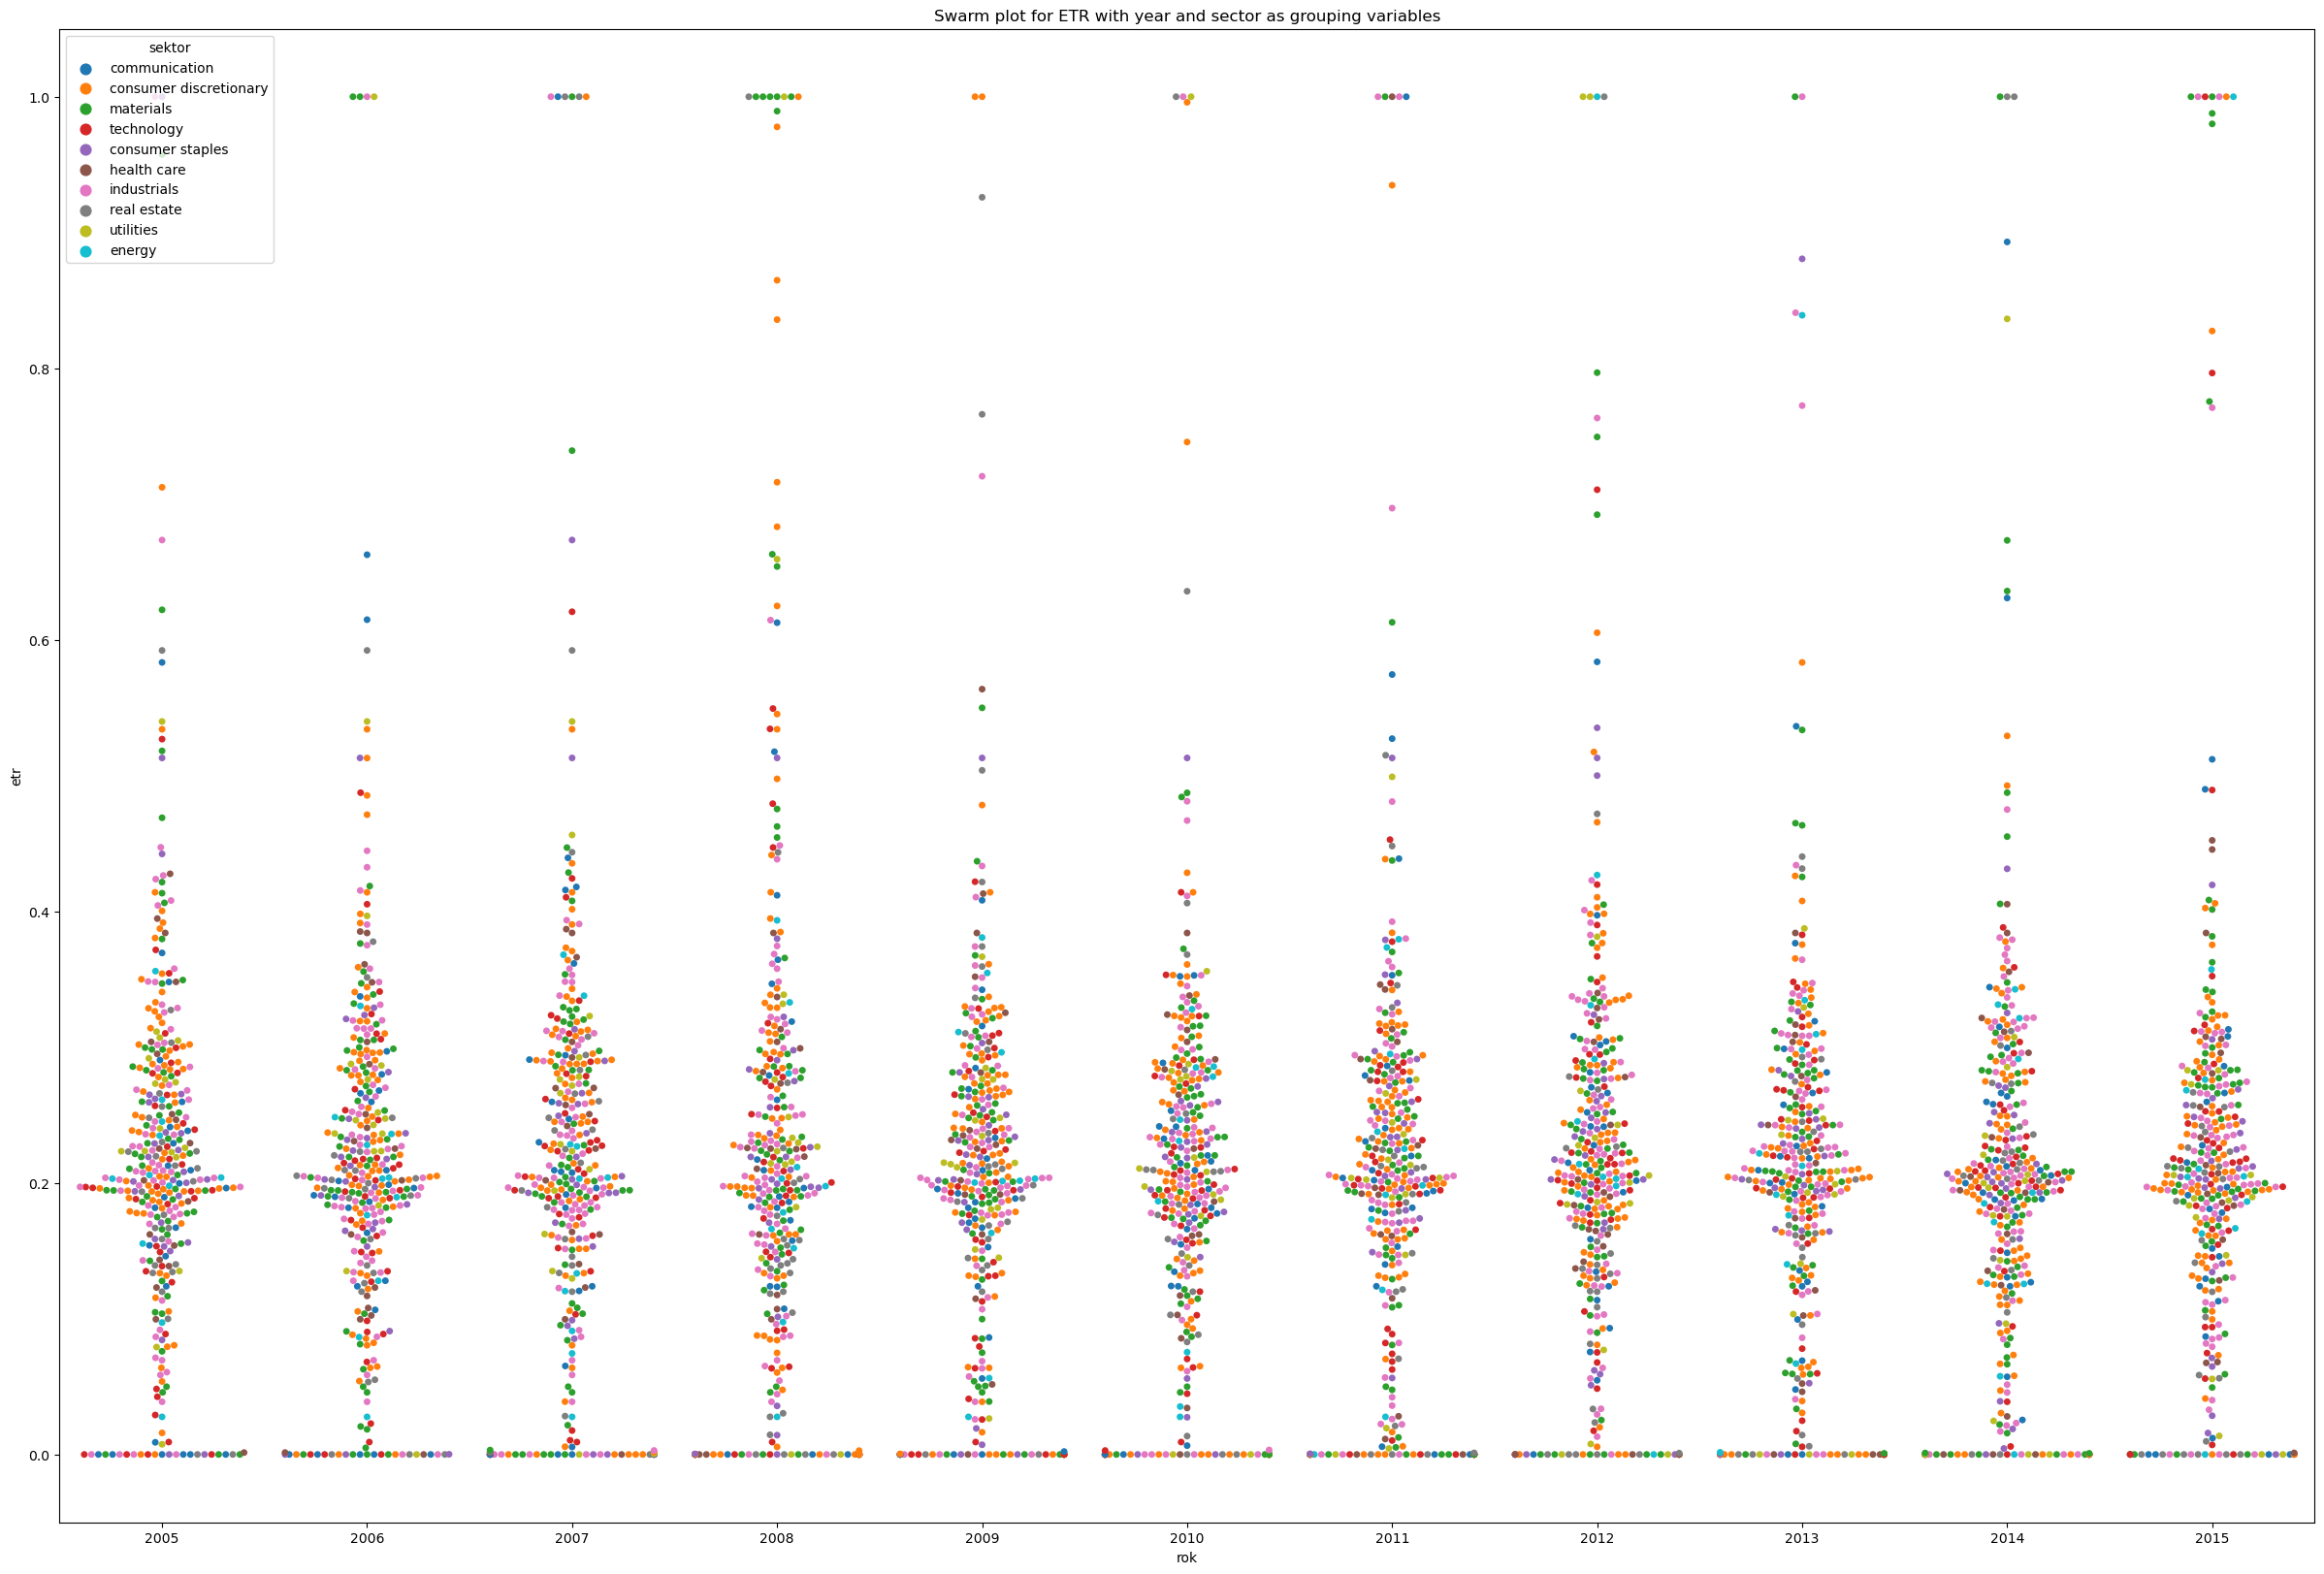

In [63]:
plt.figure(figsize=(30, 20))
sns.swarmplot(x="rok", y="etr", hue="sektor", data=df).set(
    title="Swarm plot for ETR with year and sector as grouping variables"
)
plt.show()

#### Two-way (two factor) ANOVA for searching dependencies between ETR, sector and year!

Warning! We don't have balanced data in case of sector!

In [64]:
df.sektor.value_counts()

consumer discretionary    847
industrials               748
materials                 616
technology                407
consumer staples          297
real estate               286
communication             275
health care               209
utilities                 187
energy                    121
Name: sektor, dtype: int64

In [65]:
df_ANOVA = df[["sektor", "rok", "etr"]].copy()

In [66]:
model = ols("etr ~ C(sektor) + C(rok) + C(sektor):C(rok)", data=df_ANOVA).fit()
anova_model = sm.stats.anova_lm(model, typ=2)
anova_model

sum_sq      df         F    PR(>F)
C(sektor)          0.686356     9.0  3.243397  0.000622
C(rok)             0.304307    10.0  1.294213  0.227390
C(sektor):C(rok)   2.340835    90.0  1.106169  0.233427
Residual          91.300668  3883.0       NaN       NaN

Based on above output we can conclude that sector has significant impact on ETR, but in case of year and their interaction there is no significant relation!

**Test ANOVA assumptions**

In [67]:
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.8532450199127197 0.0


We don't have normal distribution of the errors! ANOVA might be "damaged"!

**Tukey-multiple pairwise comparison for ETR~sectors**

Based on below summary we can see that significant differences are among: consumer discretionary - technology; industrials - technology; materials - real estate; materials - utilities;

In [68]:
m_comp = pairwise_tukeyhsd(endog=df["etr"], groups=df["sektor"], alpha=0.1)
print(m_comp)

                Multiple Comparison of Means - Tukey HSD, FWER=0.10                 
        group1                 group2         meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------
         communication consumer discretionary   0.0208  0.631 -0.0103   0.052  False
         communication       consumer staples   0.0001    1.0 -0.0374  0.0376  False
         communication                 energy    0.016 0.9945 -0.0329  0.0649  False
         communication            health care   0.0066    1.0 -0.0346  0.0477  False
         communication            industrials   0.0207 0.6622  -0.011  0.0523  False
         communication              materials   0.0287 0.2279 -0.0038  0.0613  False
         communication            real estate  -0.0096 0.9992 -0.0475  0.0283  False
         communication             technology  -0.0077 0.9998 -0.0428  0.0273  False
         communication              utilities   0.0207 0.9217 -0.

It seems to be reasonable to split data by sector and model them separately but there is one problem in such approach - some sectors has less observations than 250 and in such a case some ML models works not so well! Aggregation of sectors into larger groups also does not seem obvious on the basis of the above analyzes. 

### Exogenous/features variables analysis

#### Cardinal/categorical and ordinal variables

In [69]:
for col in df.columns:
    if df[col].dtype in ["int8", "int16", "int32", "int64", "object"]:
        print(col)

Ticker
Nazwa2
sektor
rok
gielda
cfc
dta
y_e_p_polity
y_BR_Democracy


As we mentioned above sectors are not balanced! 

In [70]:
df.sektor.value_counts()

consumer discretionary    847
industrials               748
materials                 616
technology                407
consumer staples          297
real estate               286
communication             275
health care               209
utilities                 187
energy                    121
Name: sektor, dtype: int64

In [71]:
df.sektor.value_counts(normalize=True)

consumer discretionary    0.212121
industrials               0.187328
materials                 0.154270
technology                0.101928
consumer staples          0.074380
real estate               0.071625
communication             0.068871
health care               0.052342
utilities                 0.046832
energy                    0.030303
Name: sektor, dtype: float64

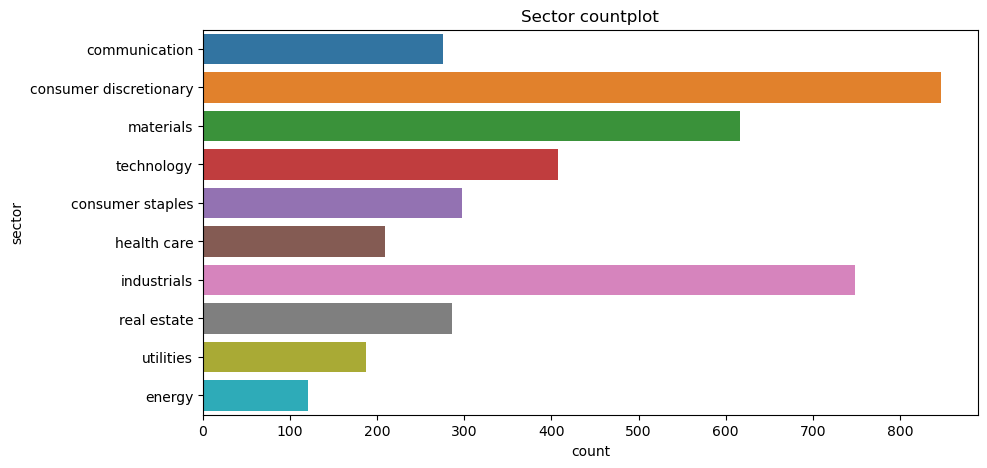

In [72]:
plt.figure(figsize=(10, 5))
sns.countplot(y="sektor", data=df, orient="h").set(
    title="Sector countplot", ylabel="sector"
)
plt.show()

Panel data are balanced - yearly

In [73]:
df.rok.value_counts()

2005    363
2006    363
2007    363
2008    363
2009    363
2010    363
2011    363
2012    363
2013    363
2014    363
2015    363
Name: rok, dtype: int64

We have large disproportions between stock exchanges. Most companies come from Poland! We have a similar number of ~ 600 from the UK and Germany.

In [74]:
df.gielda.value_counts(normalize=True)

1    0.542700
2    0.175056
3    0.154270
4    0.081142
5    0.046832
Name: gielda, dtype: float64

In [75]:
df.gielda.value_counts(normalize=False)

1    2167
2     699
3     616
4     324
5     187
Name: gielda, dtype: int64

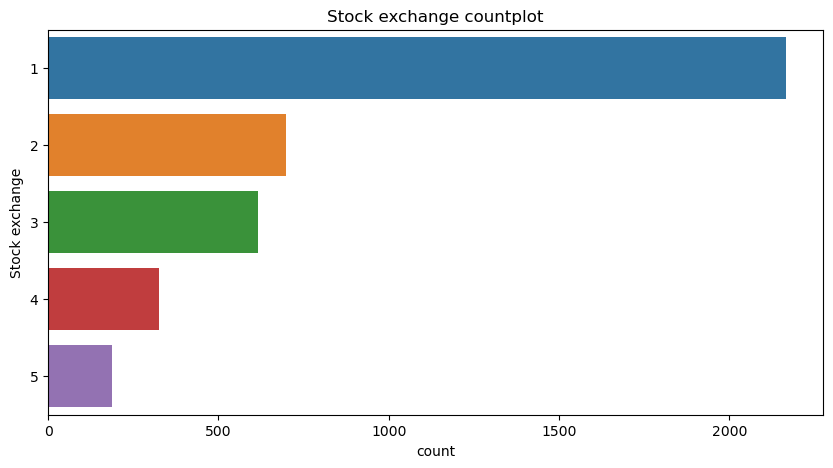

In [76]:
plt.figure(figsize=(10, 5))
sns.countplot(y="gielda", data=df, orient="h").set(
    title="Stock exchange countplot", ylabel="Stock exchange"
)
plt.show()

As we can see some of the stock exchanges have not representation in some sectors.

In [77]:
pd.crosstab(df.gielda, df.sektor)

sektor  communication  consumer discretionary  consumer staples  energy  \
gielda                                                                    
1                 165                     396               165      66   
2                  44                     143                22       0   
3                  33                     198                77      22   
4                  22                      99                33      11   
5                  11                      11                 0      22   

sektor  health care  industrials  materials  real estate  technology  \
gielda                                                                 
1               110          473        308          132         264   
2                66          127        121           88          55   
3                22           44        132            0          44   
4                11           71         22           11          33   
5                 0           33         33           55          11   

sektor  utilities  
gielda             
1              88  
2              33  
3              44  
4              11  
5              11

Almost half of the companies control foreign companies!

In [78]:
df.cfc.value_counts(normalize=True)

0    0.530178
1    0.469822
Name: cfc, dtype: float64

In [79]:
df.cfc.value_counts(normalize=False)

0    2117
1    1876
Name: cfc, dtype: int64

In [80]:
df[df.Ticker.duplicated() == False].cfc.value_counts(normalize=True)

0    0.578512
1    0.421488
Name: cfc, dtype: float64

Only ~23% of companies has double taxation agreements!

In [81]:
df.dta.value_counts(normalize=True)

0    0.764588
1    0.235412
Name: dta, dtype: float64

In [82]:
df.dta.value_counts(normalize=False)

0    3053
1     940
Name: dta, dtype: int64

In [83]:
df[df.Ticker.duplicated() == False].dta.value_counts(normalize=True)

0    0.76584
1    0.23416
Name: dta, dtype: float64

In the polity index, France is rated as less democratic than all other countries. It didn't change over the time (2005-2015)!

In [84]:
df.y_e_p_polity.value_counts()

10    3669
9      324
Name: y_e_p_polity, dtype: int64

In [85]:
pd.crosstab(df.y_e_p_polity, df.gielda)

gielda           1    2    3    4    5
y_e_p_polity                          
9                0    0    0  324    0
10            2167  699  616    0  187

BR Democracy Index shows that these countries are democratic. This variable is redundant in case of 0 variance - dichotomous variable of democratization for wester countries is not powerful weapon ;-) 

In [86]:
df.y_BR_Democracy.value_counts()

1    3993
Name: y_BR_Democracy, dtype: int64

#### Continuous variables 

In [87]:
con = list()
for col in df.columns:
    if df[col].dtype in ["float"]:
        con.append(col)

In [88]:
print(con)

['ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'etr', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'capex2_scaled', 'y_v2x_polyarchy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector']


In [89]:
con.remove("etr")

In [90]:
len(con)

31

Simple statistics - measure the position and measures of dispersion

In [91]:
df[con].describe()

ta           txt            pi          str           xrd  \
count  3.993000e+03   3993.000000   3993.000000  3993.000000   3993.000000   
mean   2.748262e+04    177.332497    646.508278     0.230383    276.556515   
std    1.492132e+05    688.278950   2279.888203     0.059021   1405.230262   
min    9.707000e-01  -4432.000000  -9571.000000     0.002400  -8046.000000   
25%    1.995960e+02      1.263000      7.630000     0.190000      0.000000   
50%    1.306357e+03     10.295500     57.599998     0.190000      0.000000   
75%    8.498754e+03    104.099998    435.479980     0.287933     59.000000   
max    2.077758e+06  12737.000000  38834.000000     0.390000  25700.000000   

                  ni         ppent        intant           dlc           dltt  \
count    3993.000000   3993.000000   3993.000000  3.993000e+03    3993.000000   
mean     1623.716504   2023.278564   2157.342155  4.100055e+03    4367.283830   
std      8366.277174   6138.074637   5754.848775  2.574102e+04   39882.356799   
min     -7946.000000      0.000000      0.000000  0.000000e+00       0.000000   
25%         6.250000     15.475100      3.178778  7.532000e+00       9.036000   
50%        47.467999     98.990997     63.099998  1.218607e+02      56.277000   
75%       477.100006    896.806030    977.000000  1.448947e+03     332.600006   
max    133690.000000  70977.000000  61718.000000  1.230633e+06  968035.000000   

              capex        revenue            cce          adv         diff  \
count   3993.000000    3993.000000    3993.000000  3993.000000  3993.000000   
mean     512.341862    8665.446007    1127.618638    10.377697    -0.059434   
std     1690.186978   24423.244547    5445.880880    97.333566     8.886640   
min        0.000000       0.000000       0.000000     0.000000  -536.810000   
25%        5.390000     165.332001      11.106000     0.000000    -0.029778   
50%       37.200001    1028.558960      80.265999     0.000000     0.006129   
75%      294.000000    6057.000000     505.705902     0.000000     0.078090   
max    27088.000000  379136.000000  134547.000000  1429.000000    92.724891   

               roa          lev        intan           rd          ppe  \
count  3993.000000  3993.000000  3993.000000  3993.000000  3993.000000   
mean      0.098791     0.227621     0.150000     0.018066     0.251550   
std       0.164280     0.165074     0.187744     0.043154     0.243654   
min      -1.251406     0.000000     0.000000     0.000000     0.000000   
25%       0.023616     0.099287     0.009025     0.000000     0.036642   
50%       0.053696     0.211663     0.056959     0.000000     0.177984   
75%       0.108630     0.321465     0.229228     0.013635     0.410003   
max       0.894326     1.000000     1.000000     0.786220     1.465866   

              sale  cash_holdings  adv_expenditure       capex2  \
count  3993.000000    3993.000000      3993.000000  3993.000000   
mean      0.649091       0.087987         0.000763     5.945120   
std       0.340890       0.094653         0.007092    42.519747   
min       0.000000       0.000000         0.000000     0.000000   
25%       0.435743       0.027982         0.000000     0.080563   
50%       0.615820       0.058665         0.000000     0.169555   
75%       0.863155       0.111434         0.000000     0.309549   
max       2.229611       0.788311         0.137655  1077.499984   

       capex2_scaled  y_v2x_polyarchy  WB_GDPgrowth      WB_GDPpc  \
count    3993.000000      3993.000000   3993.000000   3993.000000   
mean        0.005302         0.882828      2.714994  26356.329517   
std         0.035140         0.015137      2.276367  15738.690751   
min         0.000000         0.855000     -5.697152   8021.003655   
25%         0.000075         0.872000      1.540147  12599.533580   
50%         0.000157         0.882000      2.820260  14347.914580   
75%         0.000287         0.888000      3.839071  42038.500480   
max         0.580000         0.922000      7.0348

In [92]:
df.groupby("rok")[con].describe()

ta                                                                \
      count          mean            std     min         25%          50%   
rok                                                                         
2005  363.0  21179.142327  106124.756815  2.7460  144.416824   860.827148   
2006  363.0  24116.927704  124529.352764  0.9707  142.414322   907.545227   
2007  363.0  25802.802304  139174.262876  1.5590  192.549149  1105.635010   
2008  363.0  28020.303471  159662.021609  4.2955  203.434006  1201.410034   
2009  363.0  27527.199120  157065.898175  1.3742  201.380669  1257.661011   
2010  363.0  28437.529234  157337.133626  1.3524  206.831749  1355.442017   
2011  363.0  29186.751795  159958.437184  2.9862  227.351997  1544.025024   
2012  363.0  29174.033200  156614.581197  5.8400  211.786499  1626.748047   
2013  363.0  28463.985892  148975.121136  6.1060  218.262001  1716.098999   
2014  363.0  30289.355487  163142.583094  6.8790  243.739494  1769.303955   
2015  363.0  30110.808768  159588.190825  7.1010  290.251501  1839.276001   

                                 txt                                       \
               75%        max  count        mean         std          min   
rok                                                                         
2005   6997.437988  1258079.0  363.0  168.410783  608.165491  -226.000000   
2006   7249.500000  1440343.0  363.0  192.426111  780.750390  -226.000000   
2007   7315.888916  1694454.0  363.0  202.430393  768.852118  -368.000000   
2008   8044.449951  2075551.0  363.0  183.391297  857.822910  -830.000000   
2009   8607.376953  2057698.0  363.0  135.098386  668.344223 -4432.000000   
2010   8792.000000  1998158.0  363.0  169.042633  599.781954 -1501.000000   
2011   9282.700195  1965283.0  363.0  226.475578  923.259567 -1036.000000   
2012   9431.500000  1907200.0  363.0  174.461684  627.407345 -1906.000000   
2013   9512.500000  1810522.0  363.0  177.690400  587.302767  -120.870003   
2014  10472.250000  2077758.0  363.0  170.367919  530.297771  -657.343018   
2015  10587.937012  1994193.0  363.0  150.862279  482.738840 -3171.000000   

                                                   pi              \
           25%        50%         75%      max  count        mean   
rok                                                                 
2005  1.389000   9.659751  106.771999   9473.0  363.0  632.929687   
2006  1.520000   8.982000   98.555500  12331.0  363.0  711.545522   
2007  1.482083  10.559999  109.450001  10442.0  363.0  811.882115   
2008  1.309000   9.867250   78.907055  12617.0  363.0  605.529071   
2009  0.567500   6.512000   69.926331   8365.0  363.0  459.430635   
2010  0.999000   9.213000   91.469501   6563.0  363.0  698.014655   
2011  1.000250  10.741000  123.650002  12737.0  363.0  858.855997   
2012  1.121000   9.313000  131.200001   7490.0  363.0  619.366820   
2013  1.537650  15.000000  109.750000   6906.0  363.0  640.302381   
2014  1.668000  13.773000  128.002998   6780.0  363.0  594.004417   
2015  1.499500  12.917000  117.099998   4033.0  363.0  479.729753   

                                                                           \
              std          min        25%        50%         75%      max   
rok                                                                         
2005  2141.738866 -1572.000000   7.794063  51.183998  396.763489  31921.0   
2006  2430.572337  -731.099976   7.385317  45.673557  388.341492  34642.0   
2007  2591.229667  -770.000000  10.311190  63.782001  447.250000  31611.0   
2008  2531.093033 -2915.403076   4.707000  43.258999  364.000000  34283.0   
2009  1958.369800 -4659.000000   2.560200  29.874001  235.467506  25124.0   
2010  2085.230170 -4825.000000   7.334950  60.370998  508.744507  20491.0   
2011  3094.069005 -2911.000000   8.619000  75.291000  542.700012  38834.0   
2012  2005.876786 -5375.000000   8.431625  79.000999  467.449997  23022.0   
2013  2285.301328 -7688.000000  10.93

As we can clearly see: in our continuous variables there is a lot of outliers. Many distributions are right skewed. Right now we see that maybe feature clipping will be a nice approach to handle outliers! We will consider this transformation. What is more some variables looks like power law distribution, so here logarithm might be good idea. **Based on expert knowledge, the distribution of accounting variables are in line with expectations and their change over time.** 

**Histogram plots - data from 2005 - 2015** 

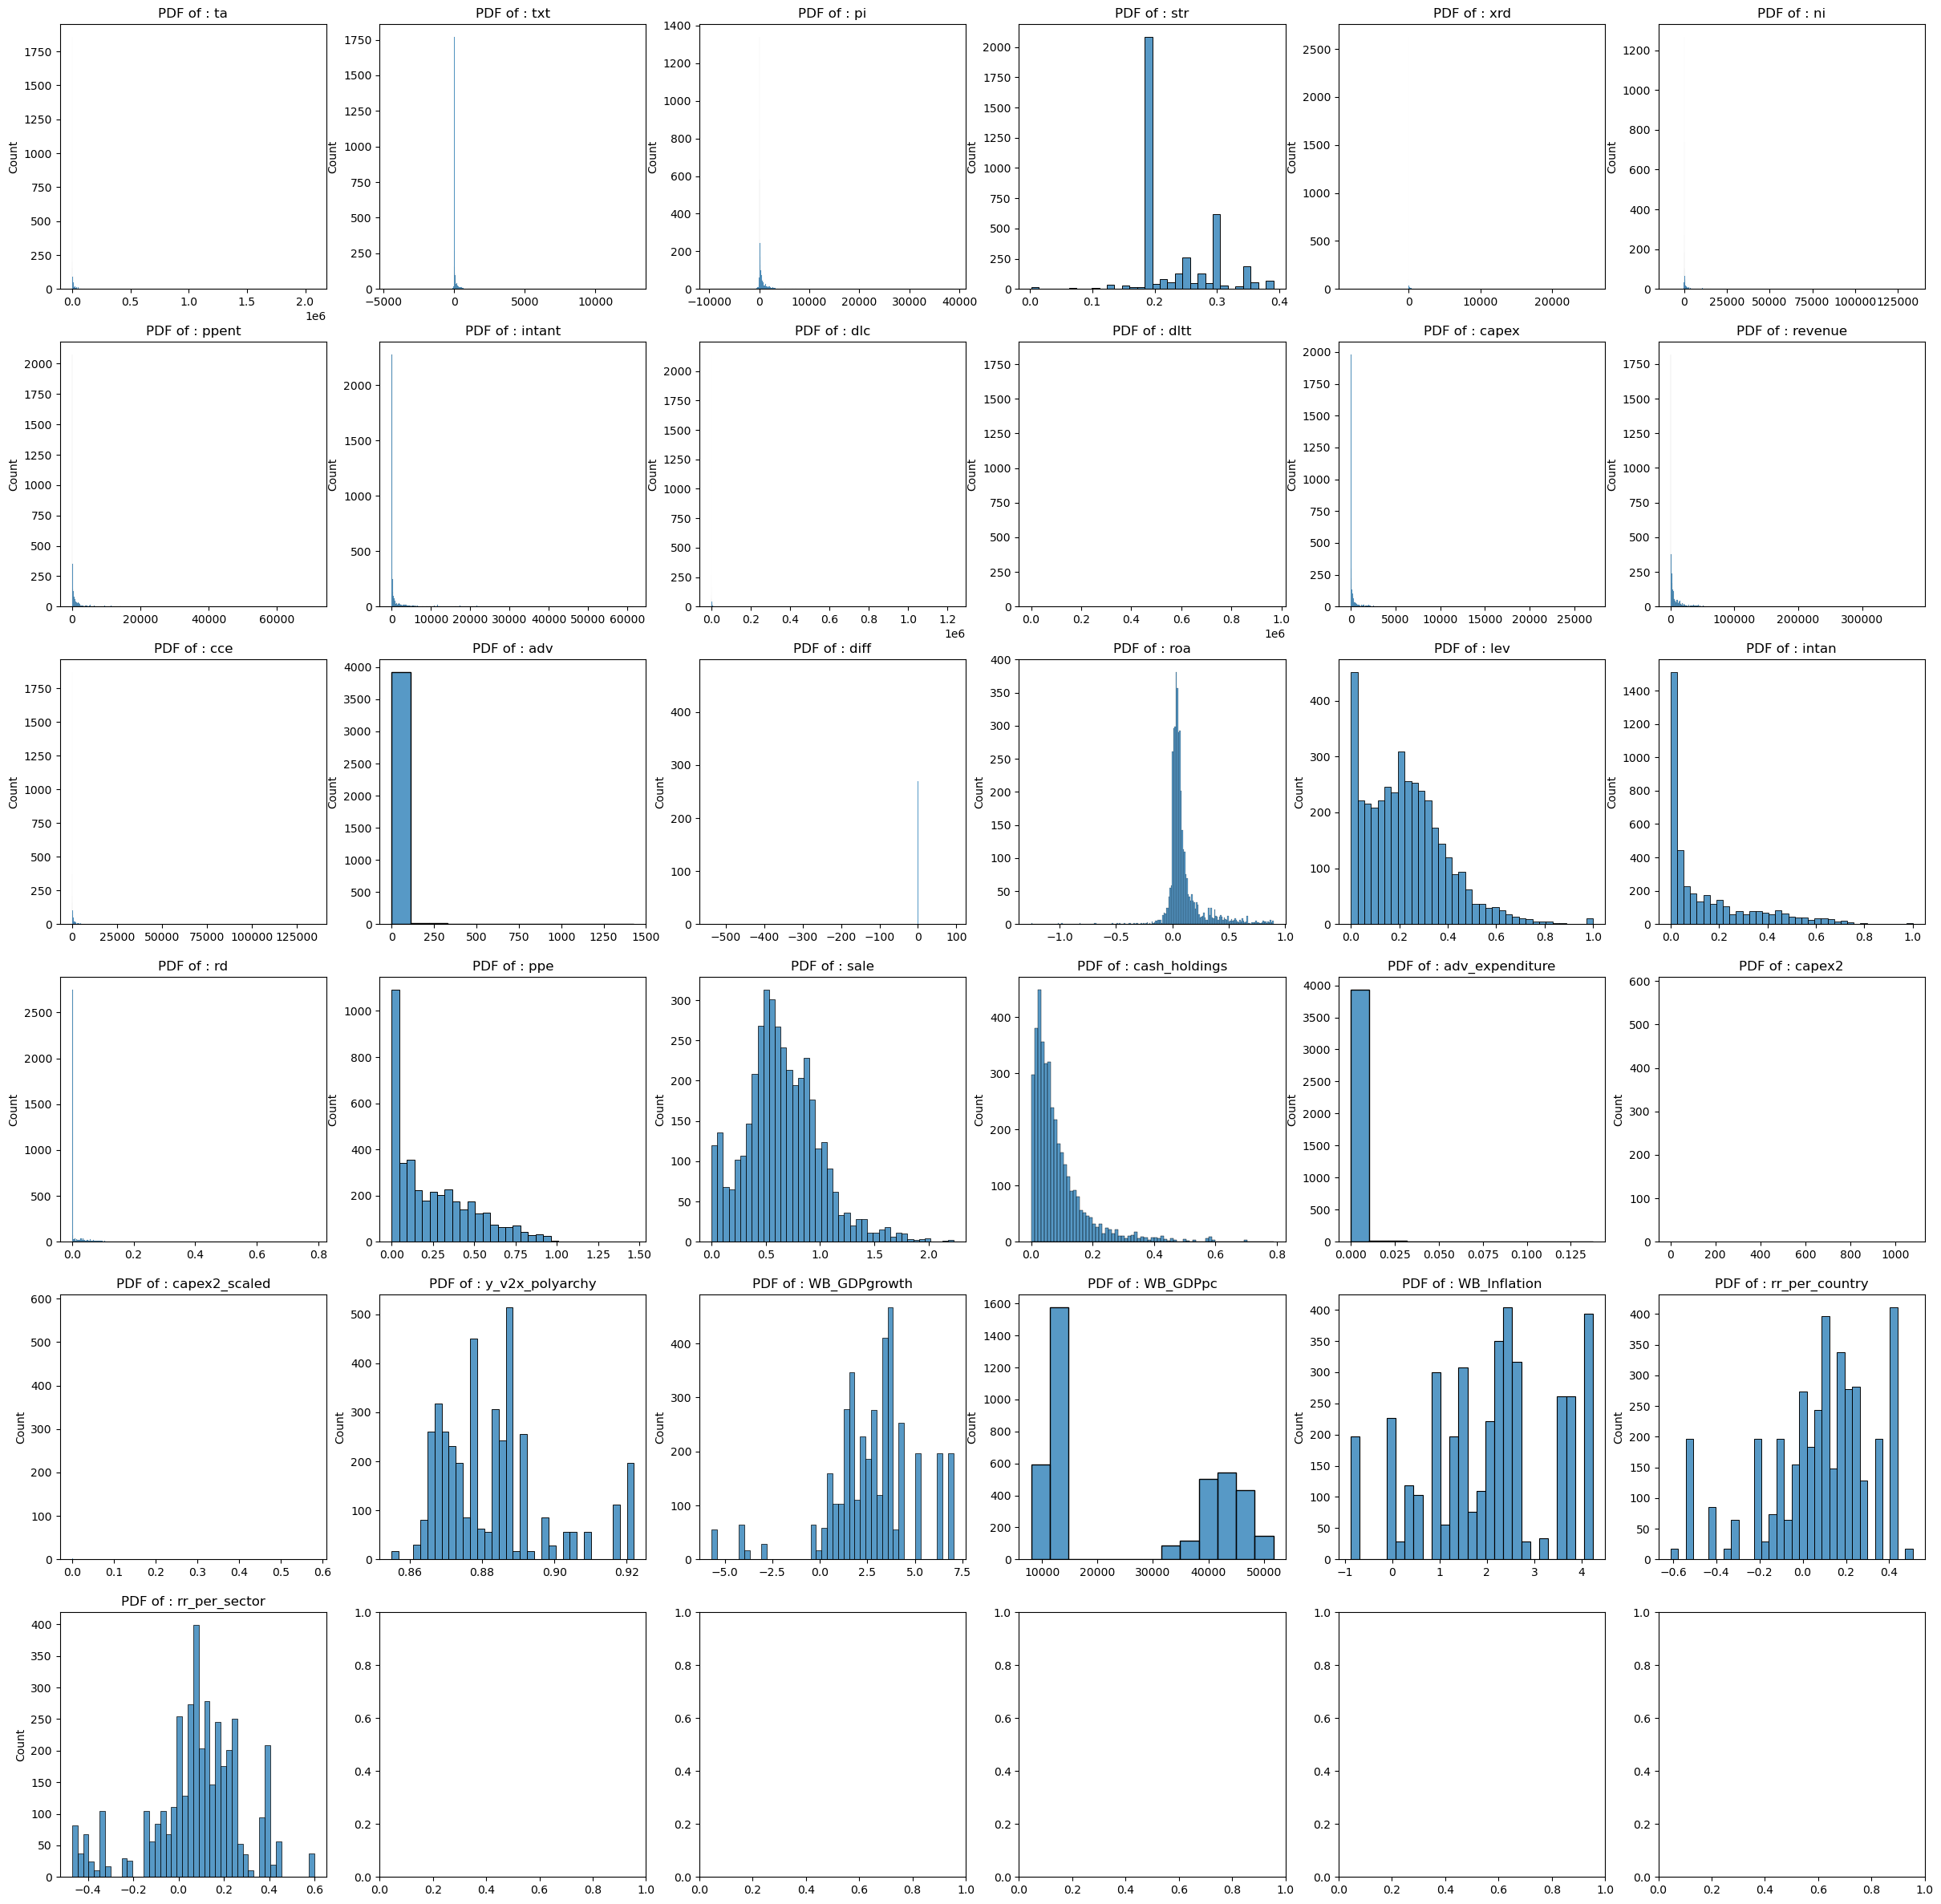

In [93]:
fig, axes = plt.subplots(ncols=6, nrows=6, figsize=(30, 30))
for i, ax in zip(con, axes.flat):
    sns.histplot(df[i], ax=ax).set(title=f"PDF of : {i}", xlabel="")
plt.show()

**Density plots for years: 2015, 2013, 2011, 2008, 2005 separately**

We see that the distributions are relatively constant over time. Possible changes result rather from changes in only a few companies. Something happens in case of *intant*, *capex* in 2015. These plots illustrates business cycle in our opinion! - we can observe clearly impact of the crisis. Although the clear change in the distribution of some variables in 2015 is puzzling and at the same time sad. The models may have had significant distortion.

##### Legend: blue: 2015; black:2013 red: 2011; green: 2008; purple:2005;

/Users/michalwozniak/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/michalwozniak/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/michalwozniak/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an ax

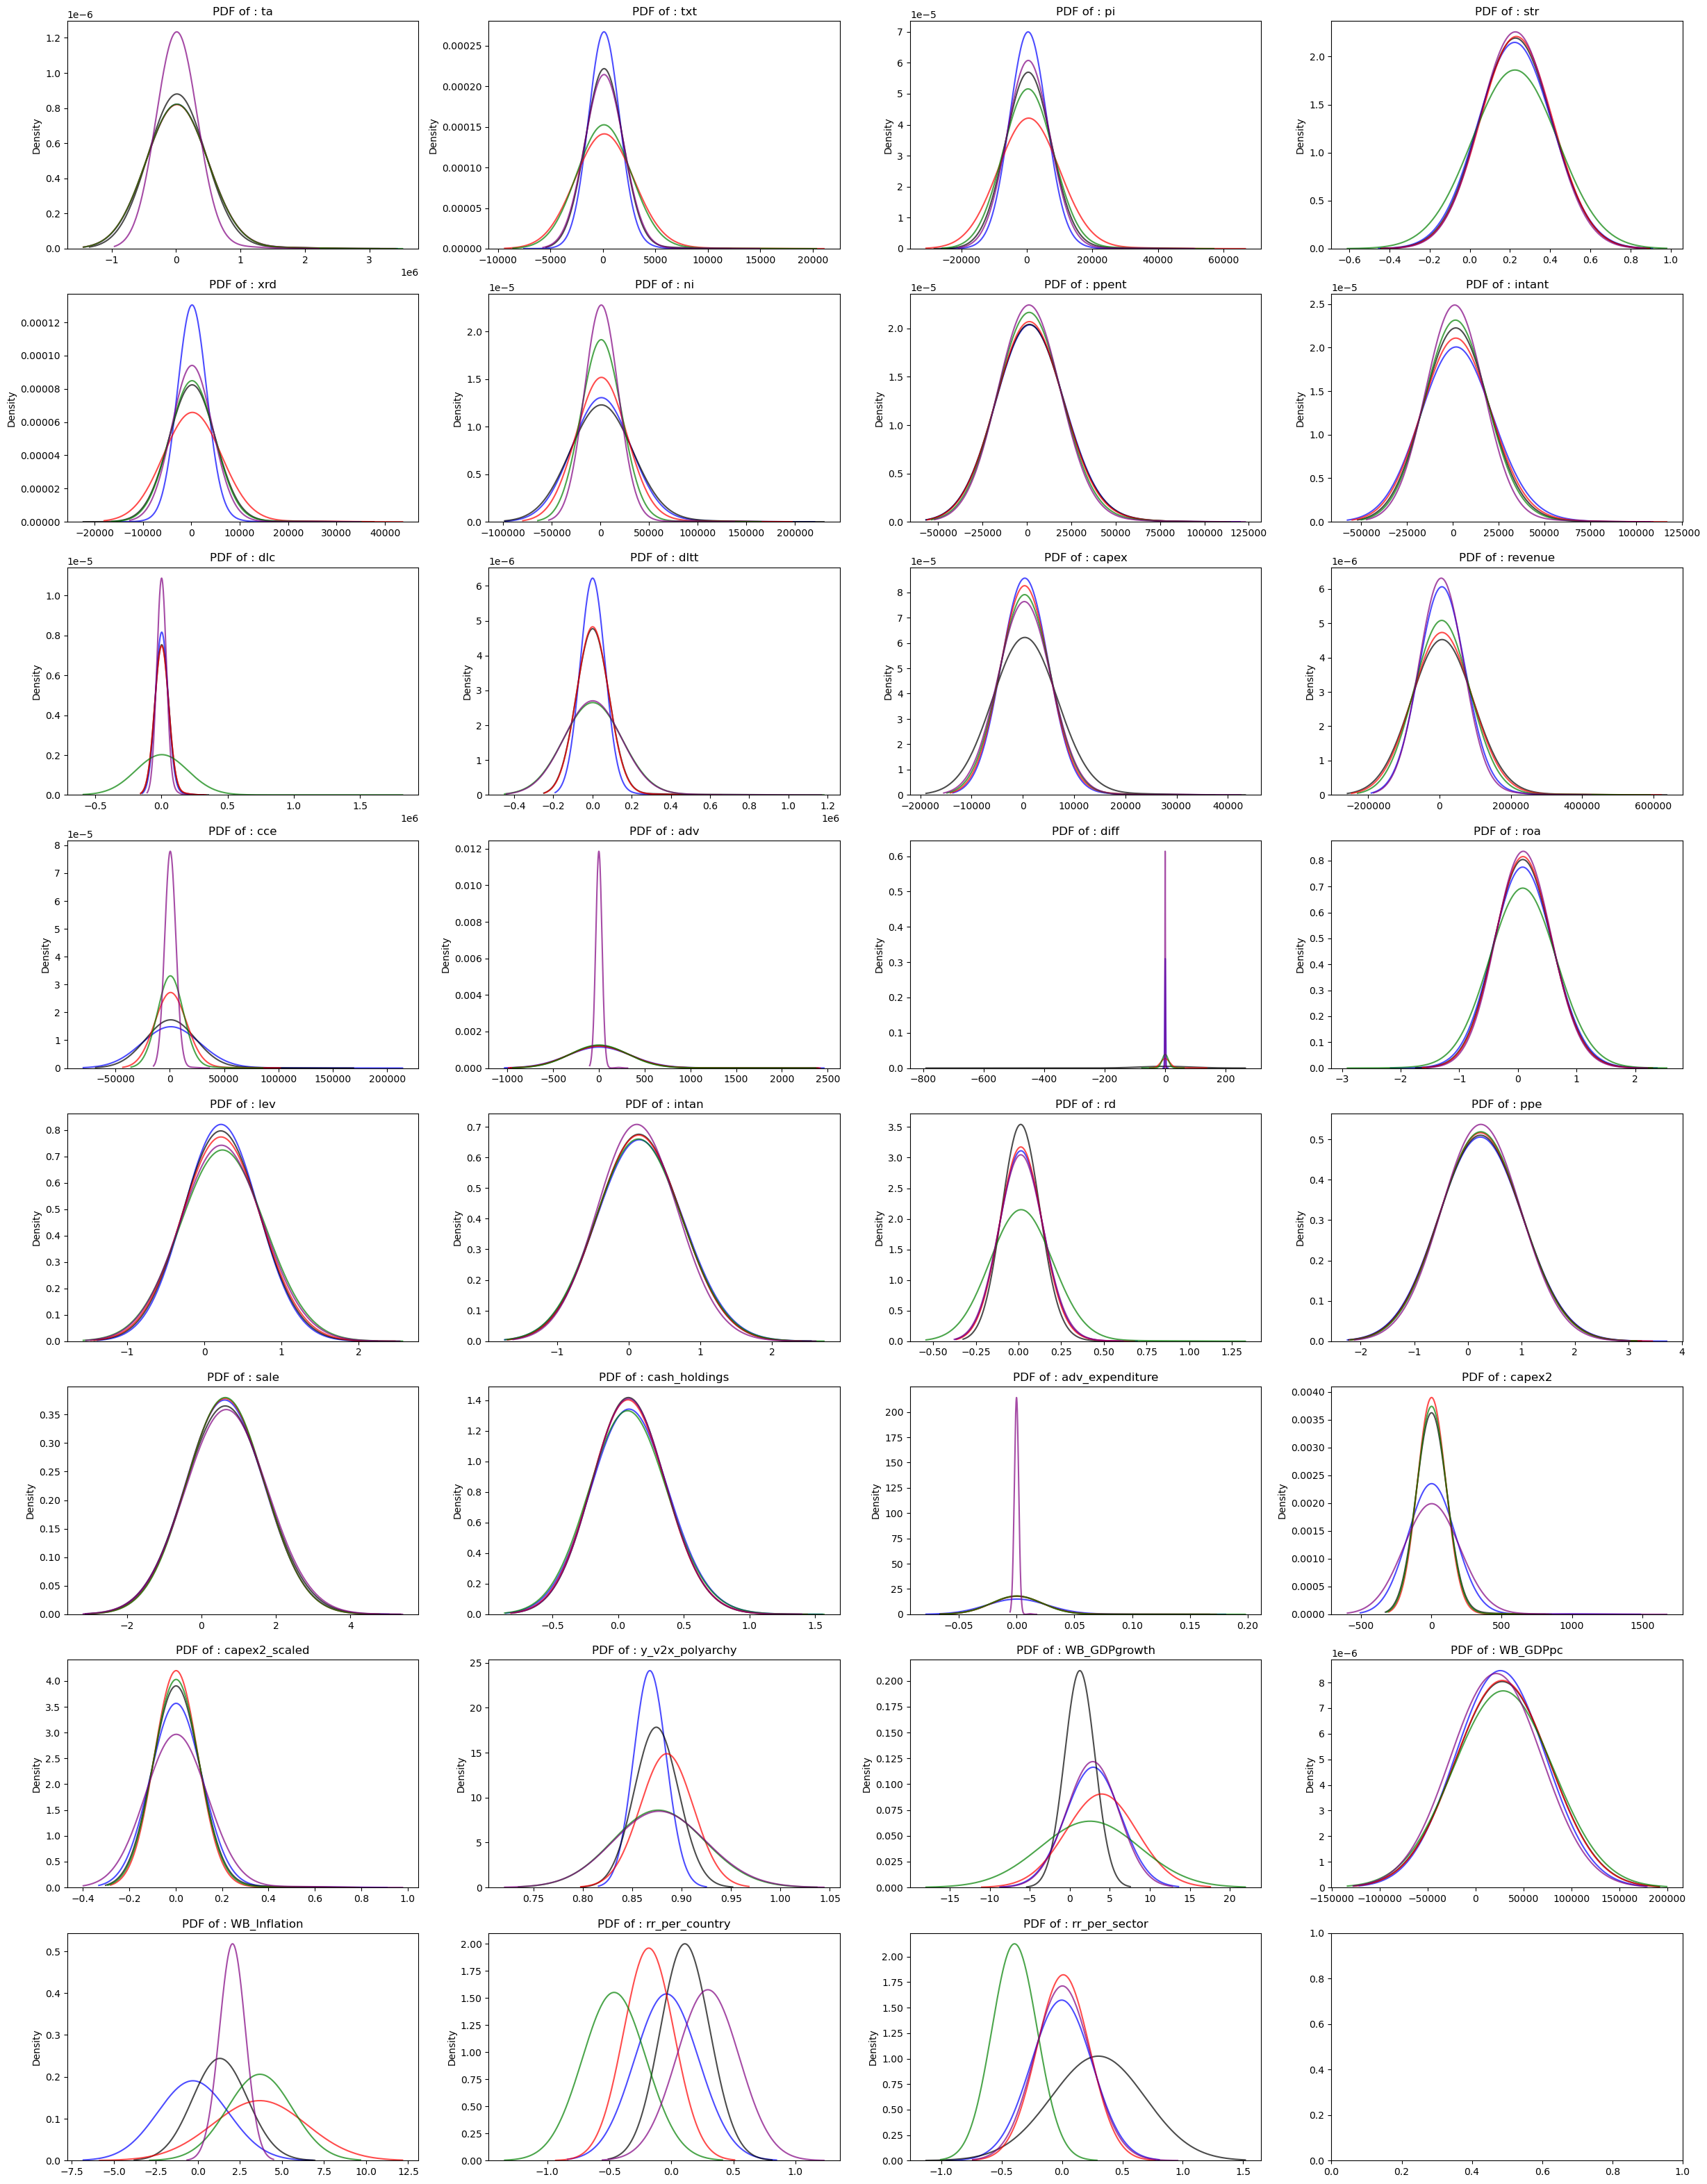

In [94]:
fig, axes = plt.subplots(ncols=4, nrows=8, figsize=(30, 40))

colors = {2015: "blue", 2013: "black", 2011: "red", 2008: "green", 2005: "purple"}

for col, ax in zip(con, axes.flat):
    for year, color in colors.items():
        sns.distplot(
            df[df.rok == year][col],
            ax=ax,
            kde_kws={"bw": 3, "alpha": 0.7},
            hist=False,
            color=color,
        ).set(title=f"PDF of : {col}", xlabel="")

plt.show()

**Box plots - data from 2005 - 2015**

We see based on the boxplots that data points are very concentrated. The data resulting from the transformation (see description of the data at the beginning) are only represented by less wild distributions. As we sad, we see a lot out **outliers** here, but we believe that we should not raise them! We will try to handle this problem in feature generation part of this research.

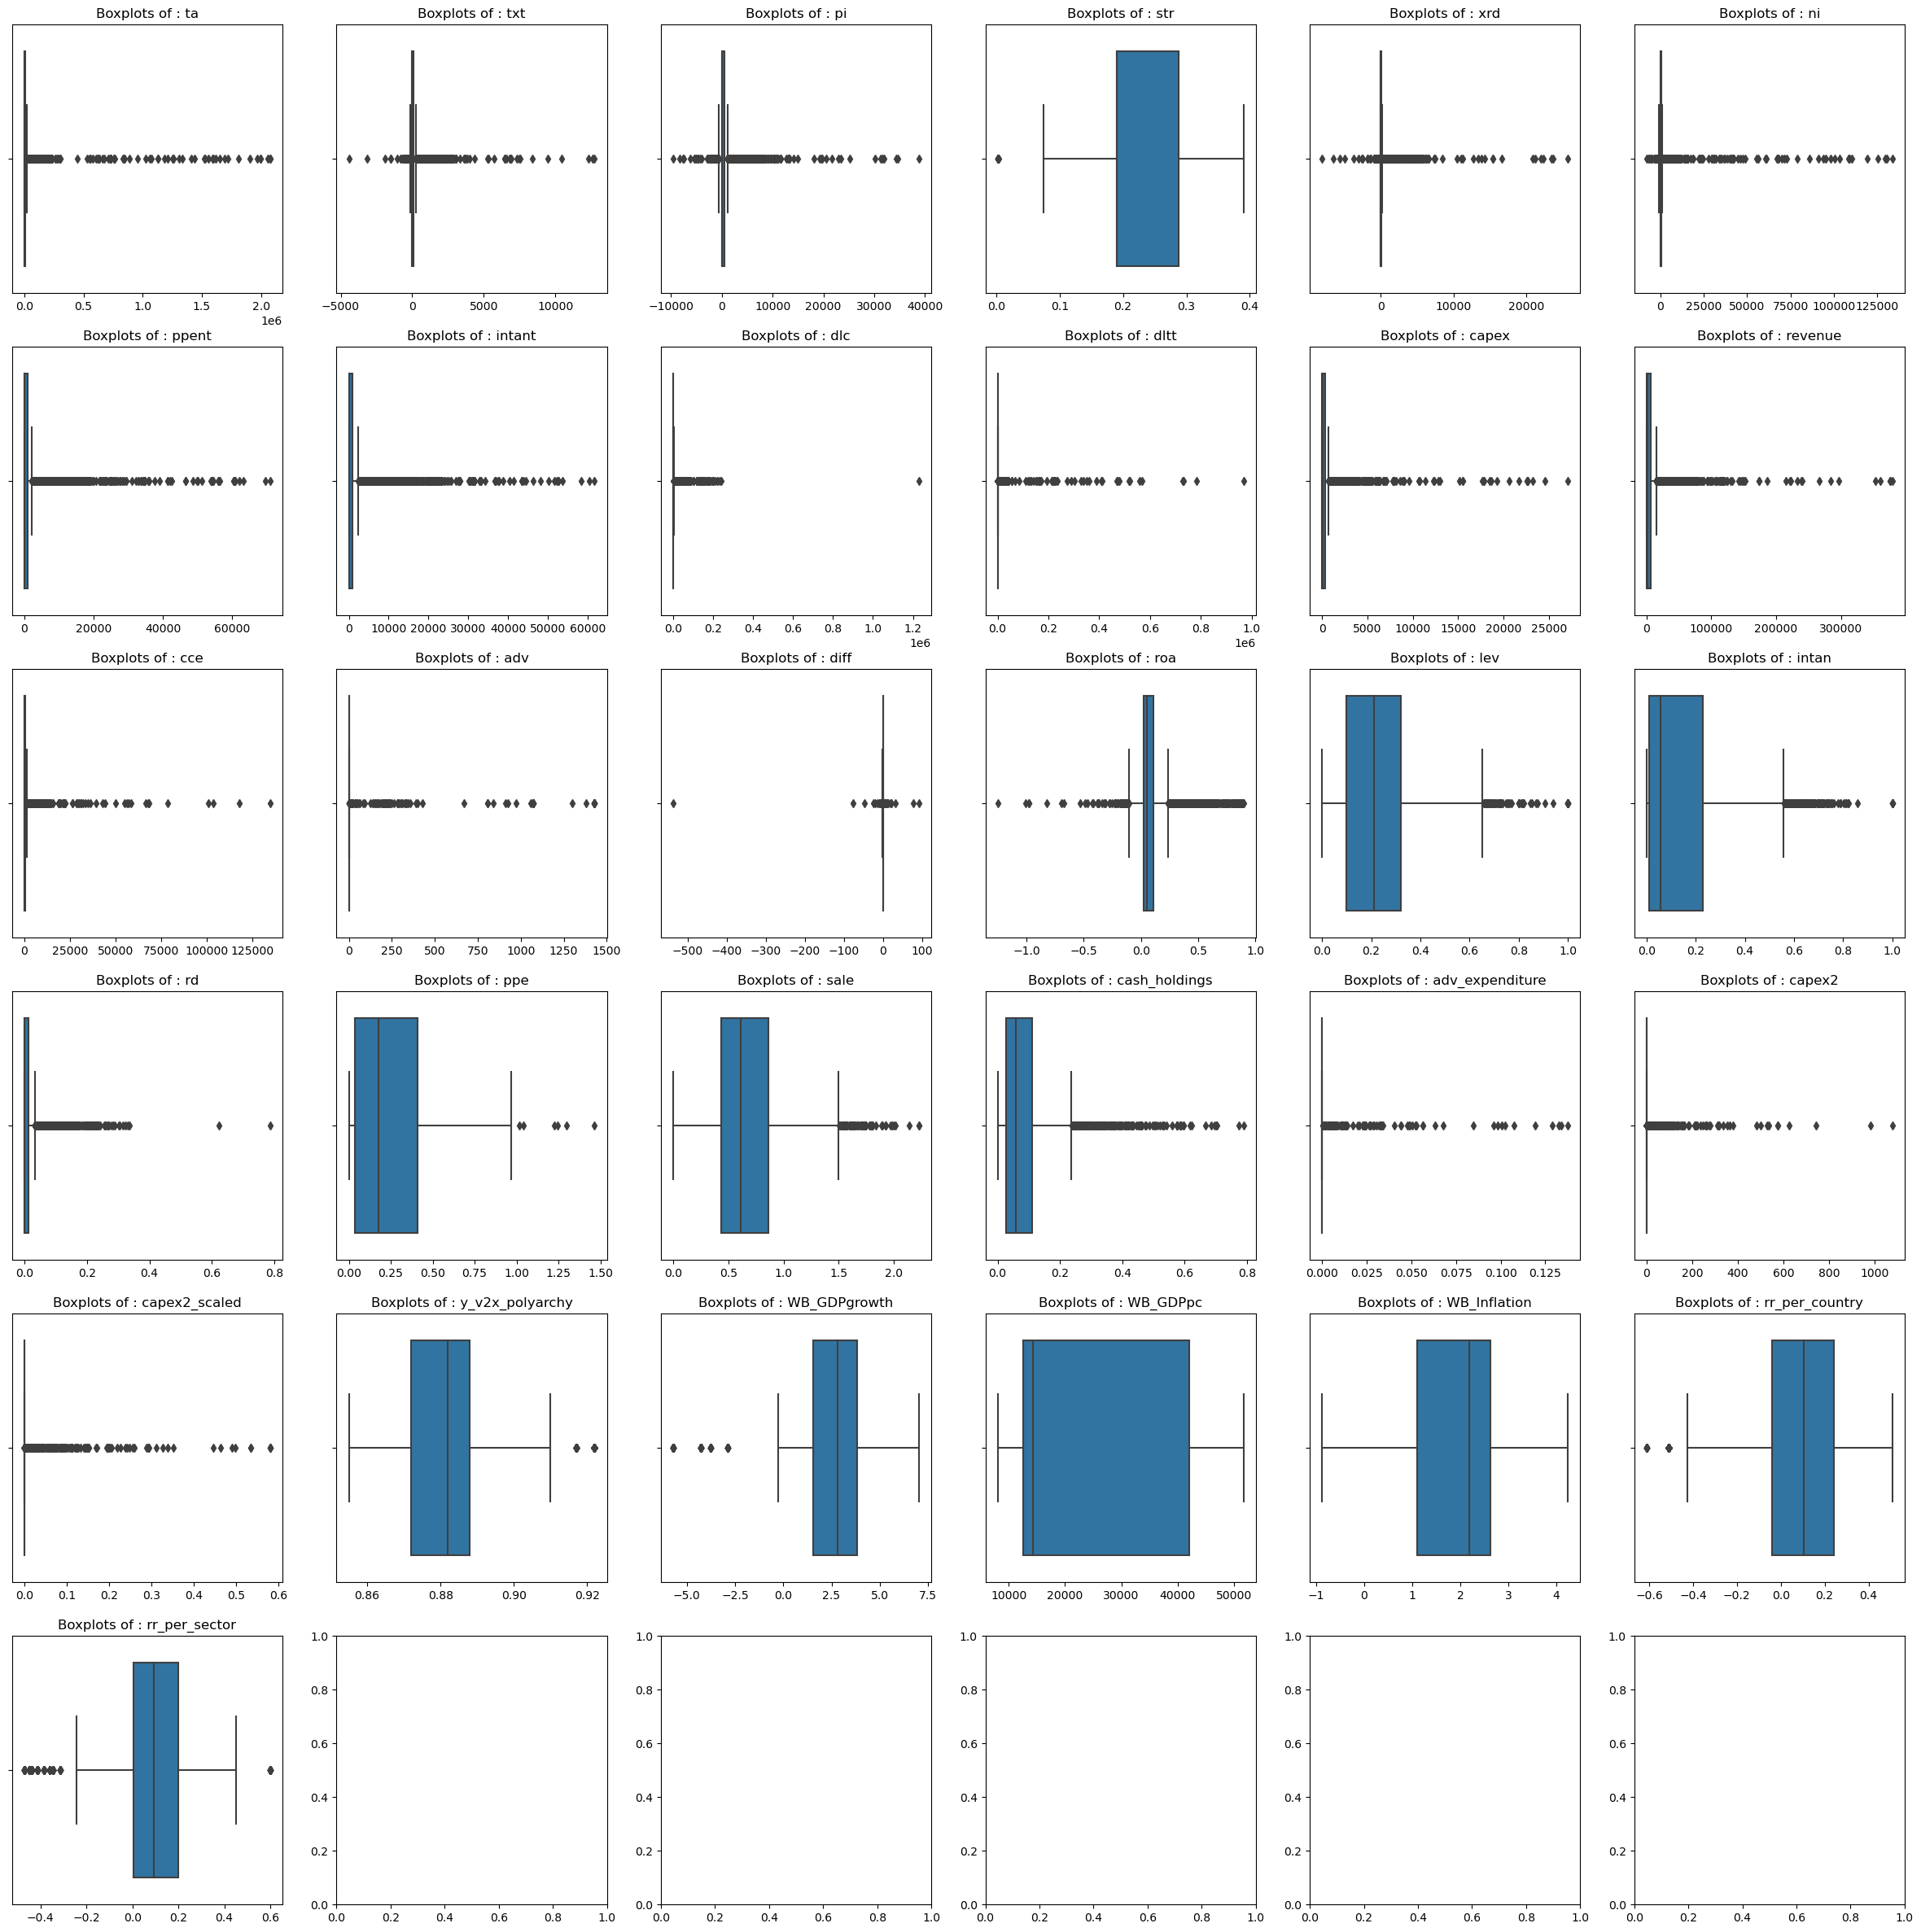

In [98]:
fig, axes = plt.subplots(ncols=6, nrows=6, figsize=(30, 30))
for i, ax in zip(con, axes.flat):
    sns.boxplot(x=df[i], ax=ax).set(title=f"Boxplots of : {i}", xlabel="")
plt.show()

**Regplot - data from 2005 - 2015**

We see that almost all variables show no linear relationship between the target variable and the explanatory variable. Now it is clear that this problem is non trivial :-)

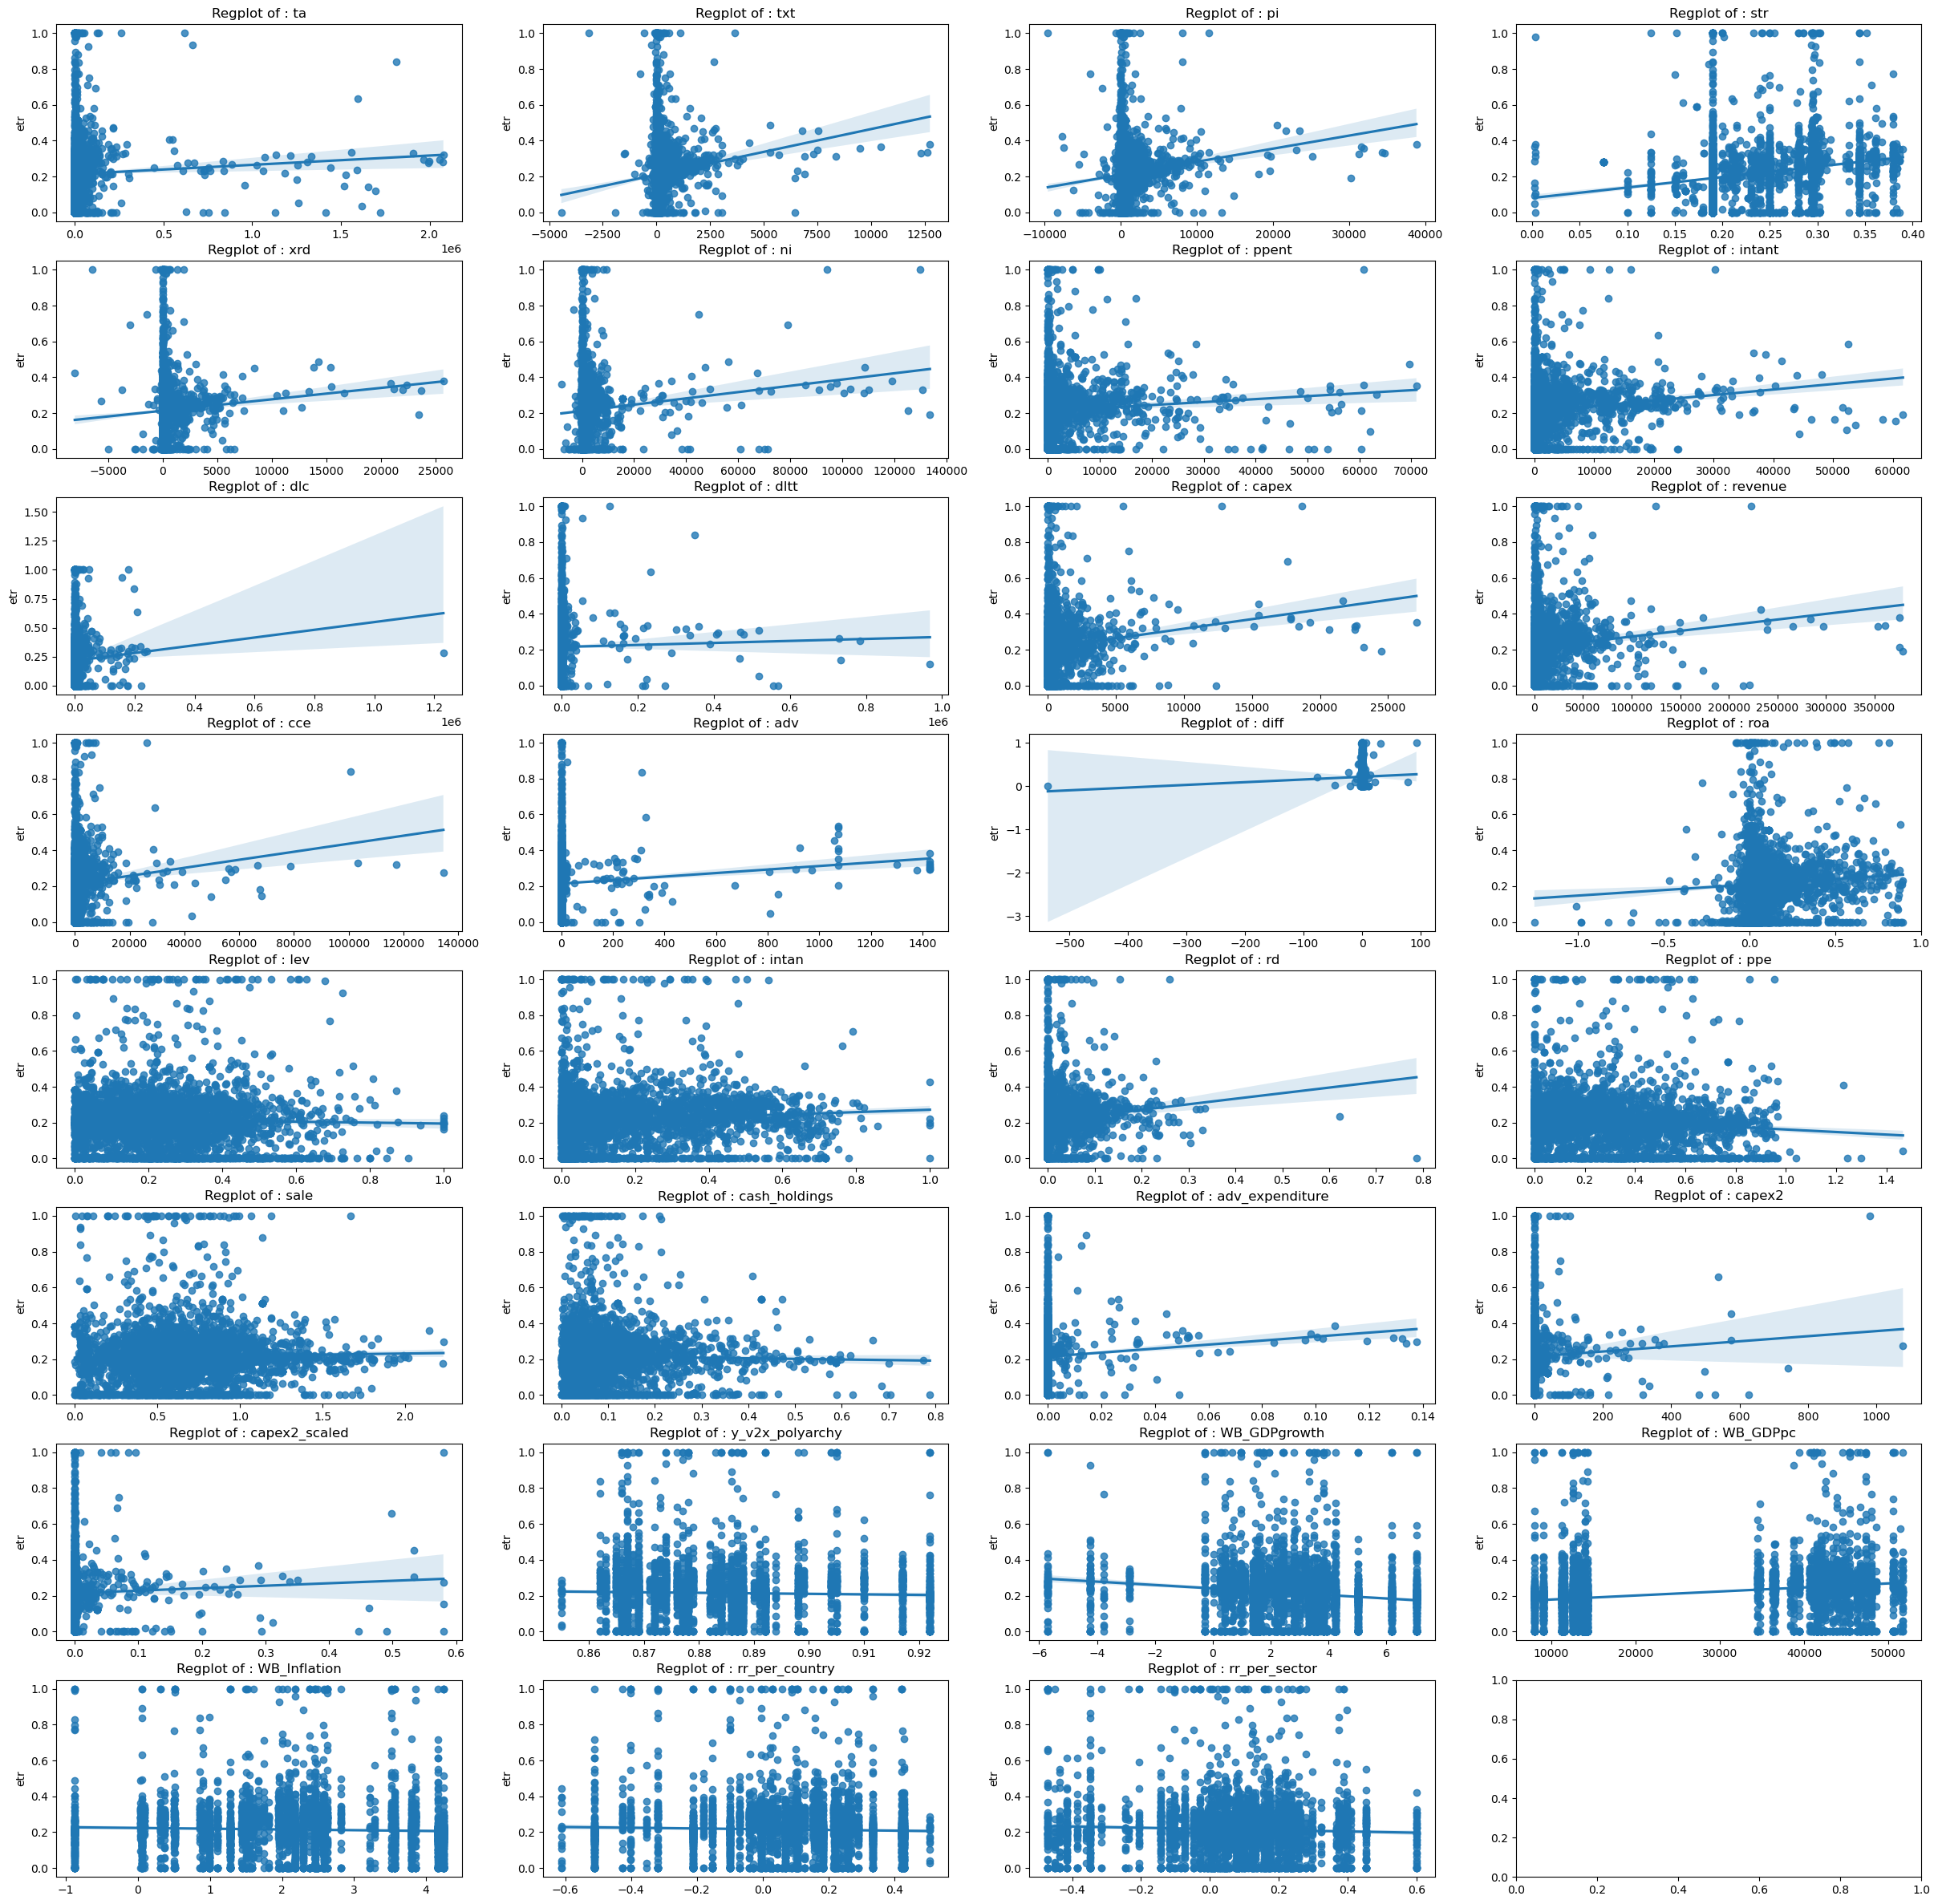

In [99]:
fig, axes = plt.subplots(ncols=4, nrows=8, figsize=(30, 30))
for i, ax in zip(con, axes.flat):
    sns.regplot(x=df[i], y=df["etr"], ax=ax).set(title=f"Regplot of : {i}", xlabel="")
plt.show()

**Kendall tau correlation matrix - measure of association**

We clearly see that in the data there is no problem of too high correlation between variables (collinearity~>0.80). Variables which have greater correlation that 0.85 are transformations, so right now it's not a problem. 

In [100]:
con.append("etr")
corr = df[con].corr("kendall")
foo = pd.DataFrame(corr.abs().unstack().sort_values(ascending=False))
foo = foo[foo[0] != 1]
foo = foo[foo.duplicated() == False]
foo.head(10)

0
capex2          capex2_scaled  1.000000
adv_expenditure adv            0.990677
pi              ni             0.833199
rd              xrd            0.817093
revenue         ta             0.782031
pi              txt            0.761797
cce             ta             0.746758
dlc             ta             0.721881
revenue         cce            0.680492
ta              capex          0.664255

It's very visible that baseline data (ta-cce) are very correlated!

**Correlation plot - 2005 - 2015**

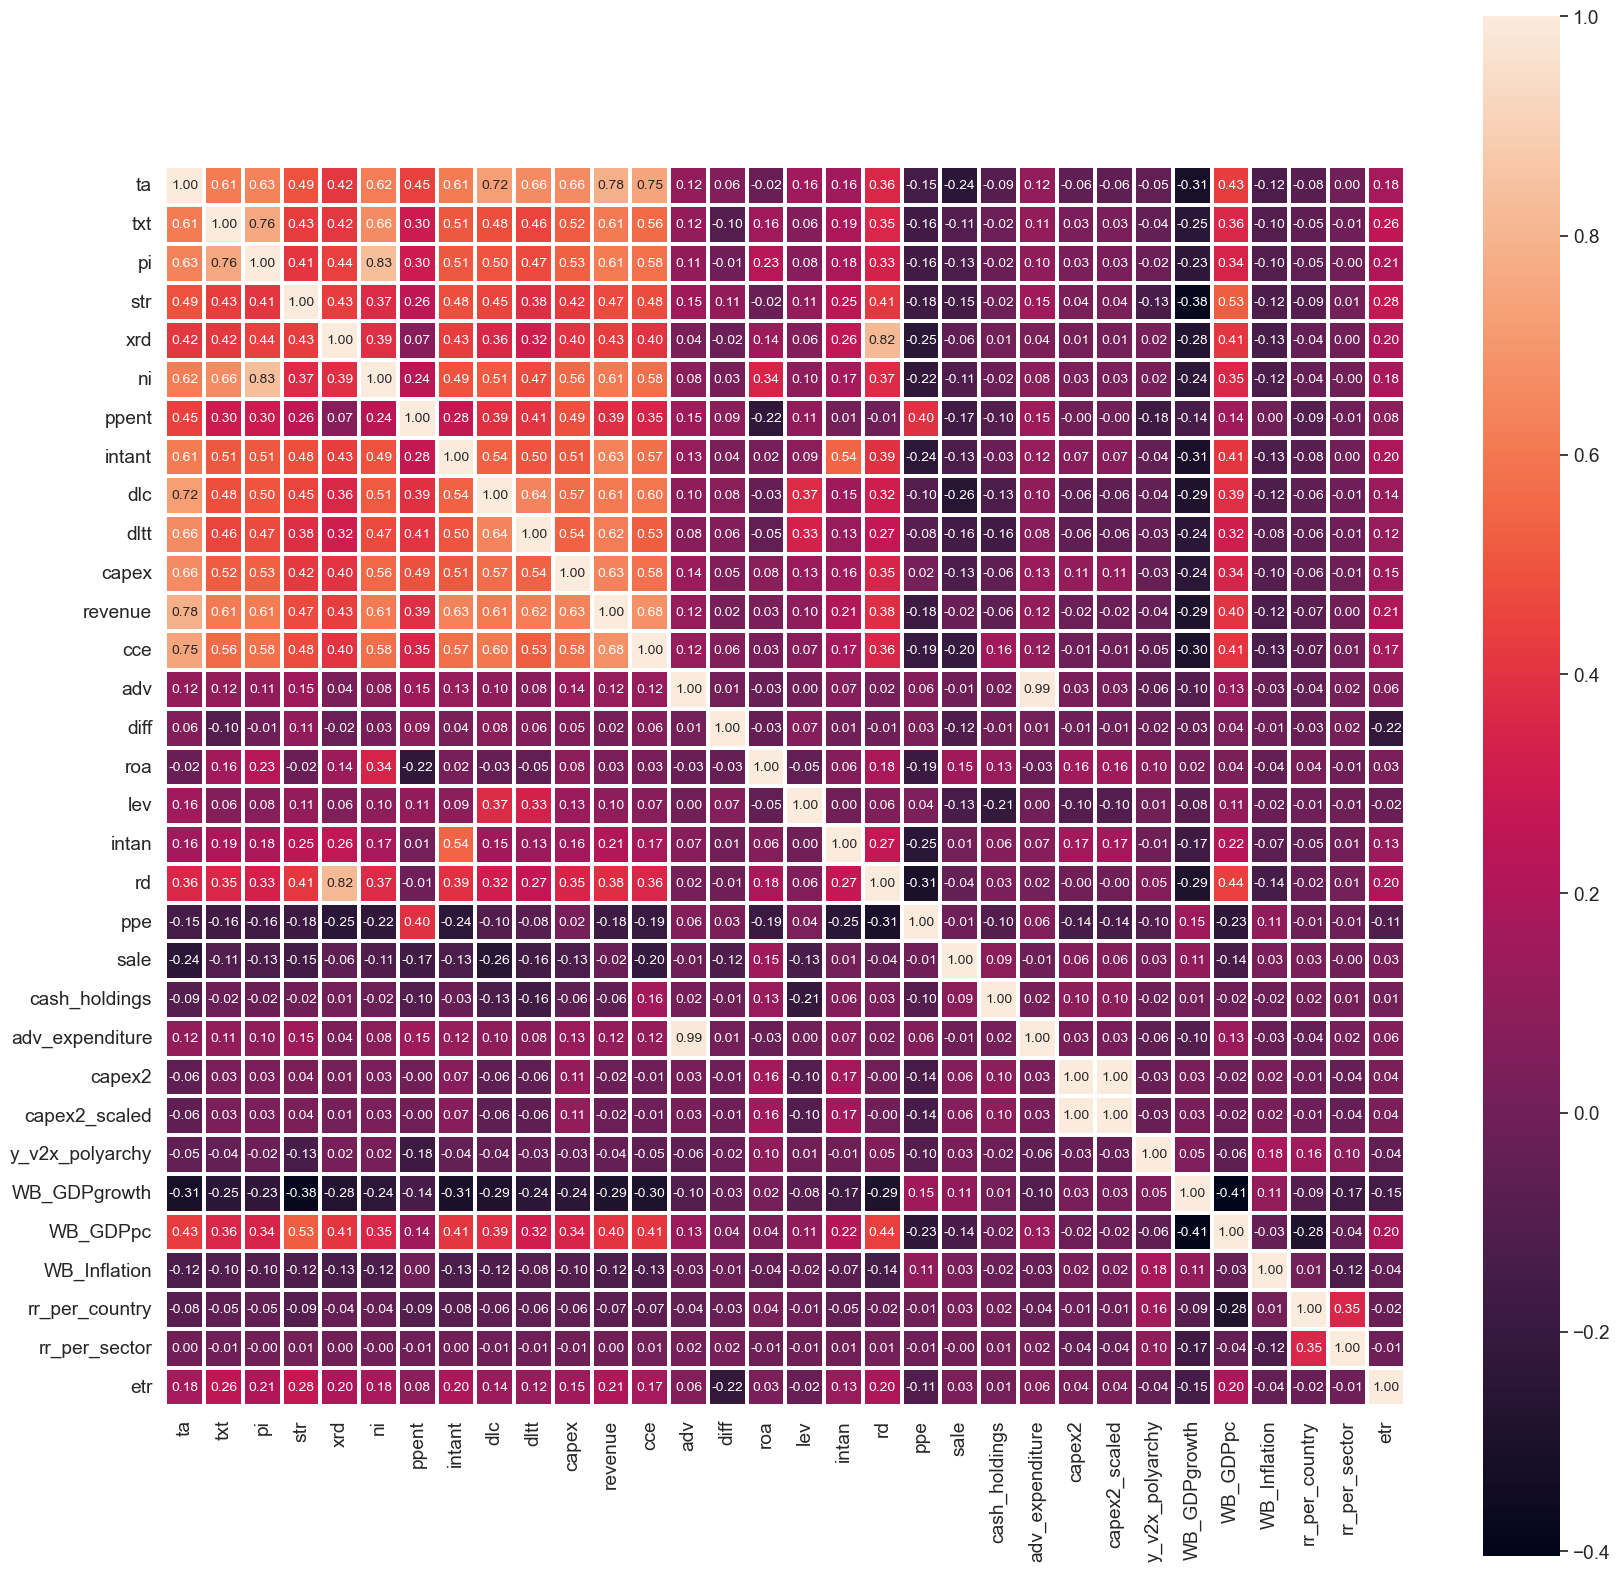

In [101]:
corr = df[con].corr("kendall")
plt.figure(figsize=(20, 20))
sns.set(font_scale=1.25)
sns.heatmap(
    corr, linewidths=1.5, annot=True, square=True, fmt=".2f", annot_kws={"size": 10}
)
plt.show()

**Correlation plot - 2015**

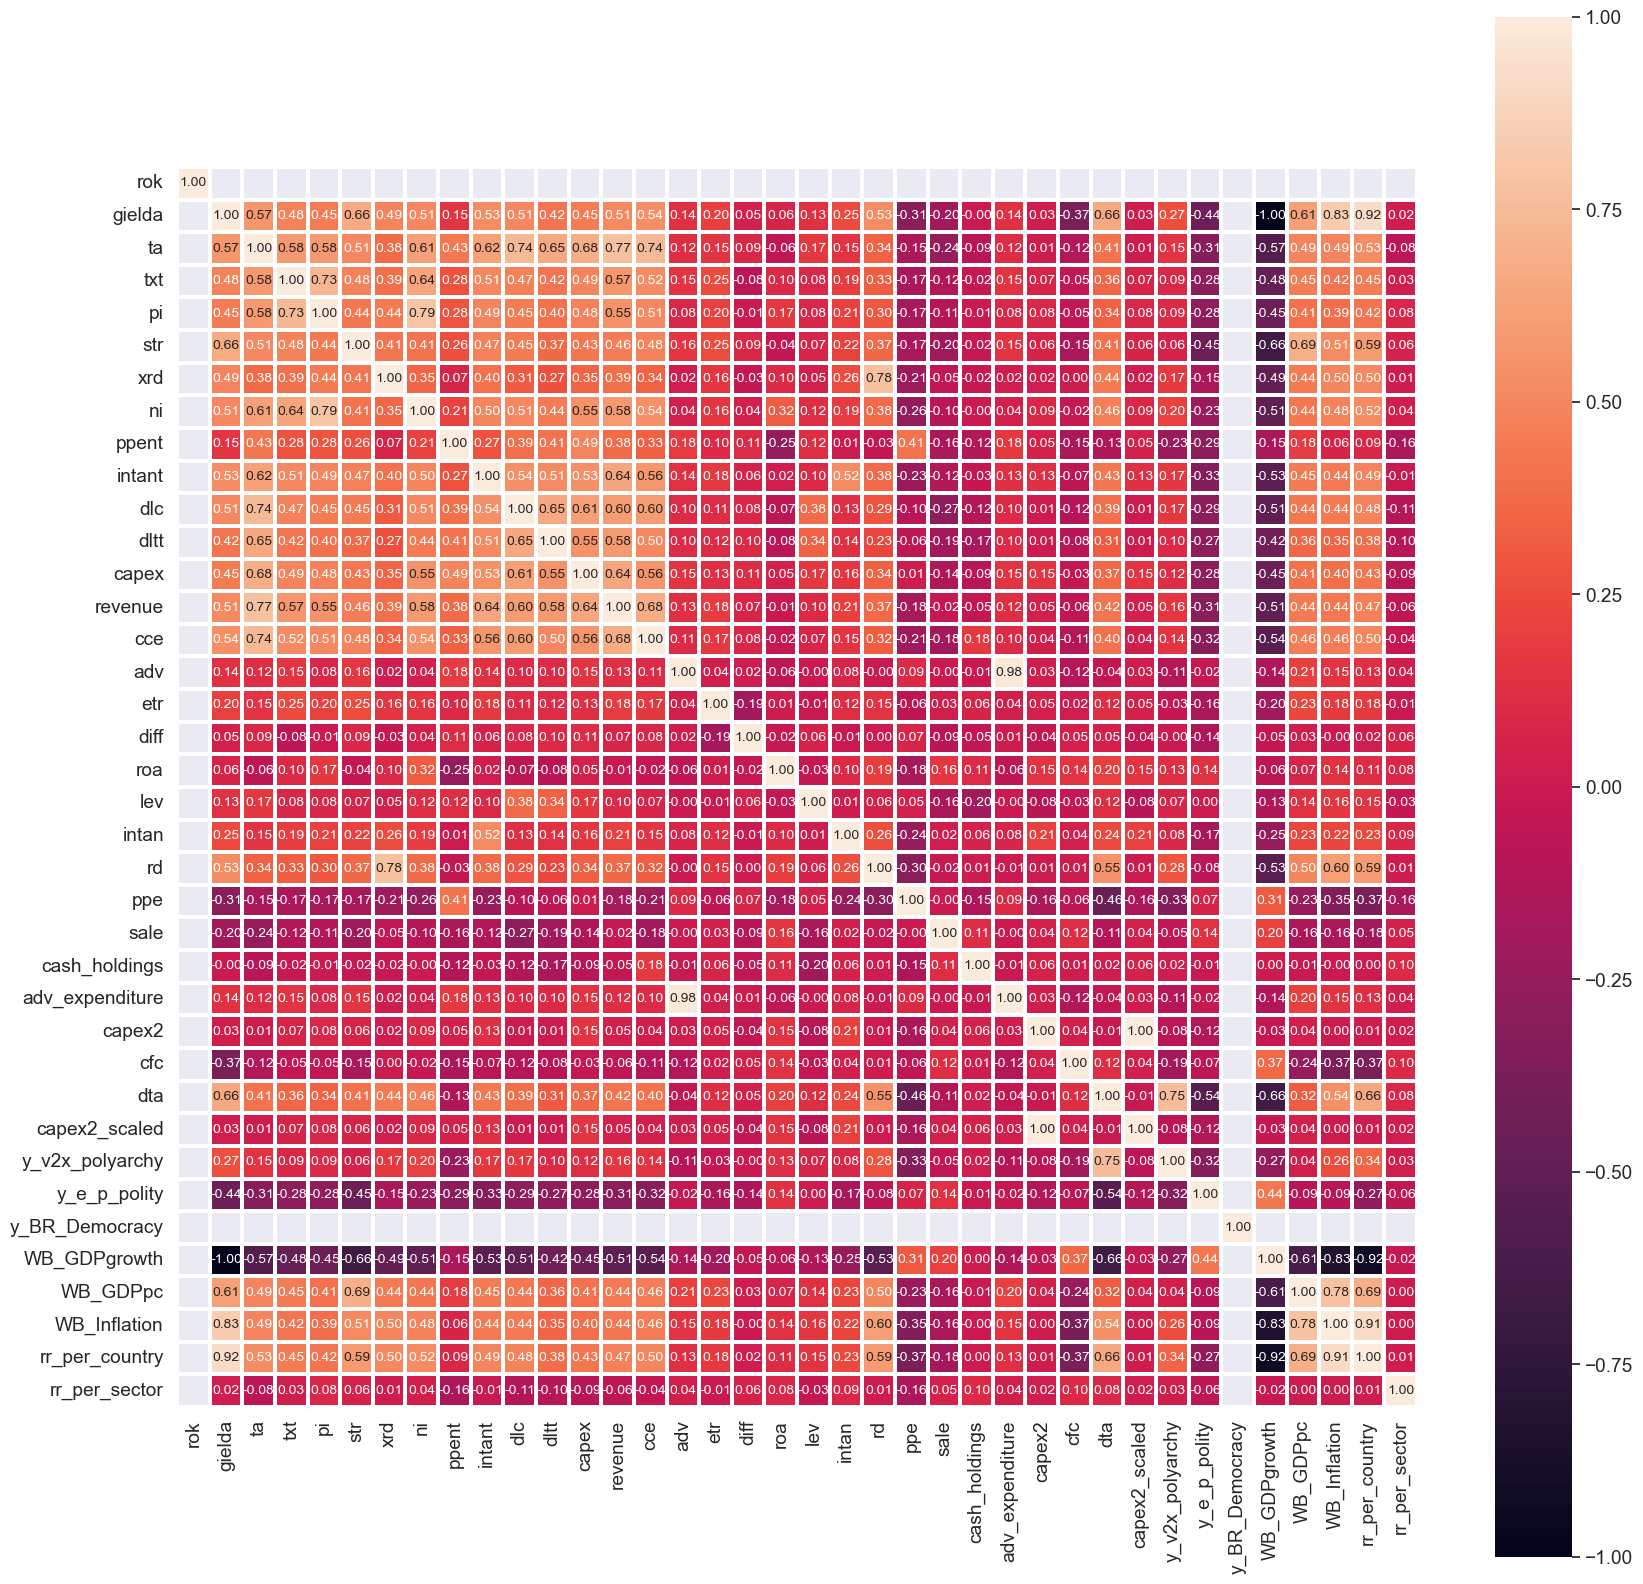

In [102]:
corr = df[con]
corr = df[df.rok == 2015].corr("kendall")
plt.figure(figsize=(20, 20))
sns.set(font_scale=1.25)
sns.heatmap(
    corr, linewidths=1.5, annot=True, square=True, fmt=".2f", annot_kws={"size": 10}
)
plt.show()

**Correlation plot - 2008**

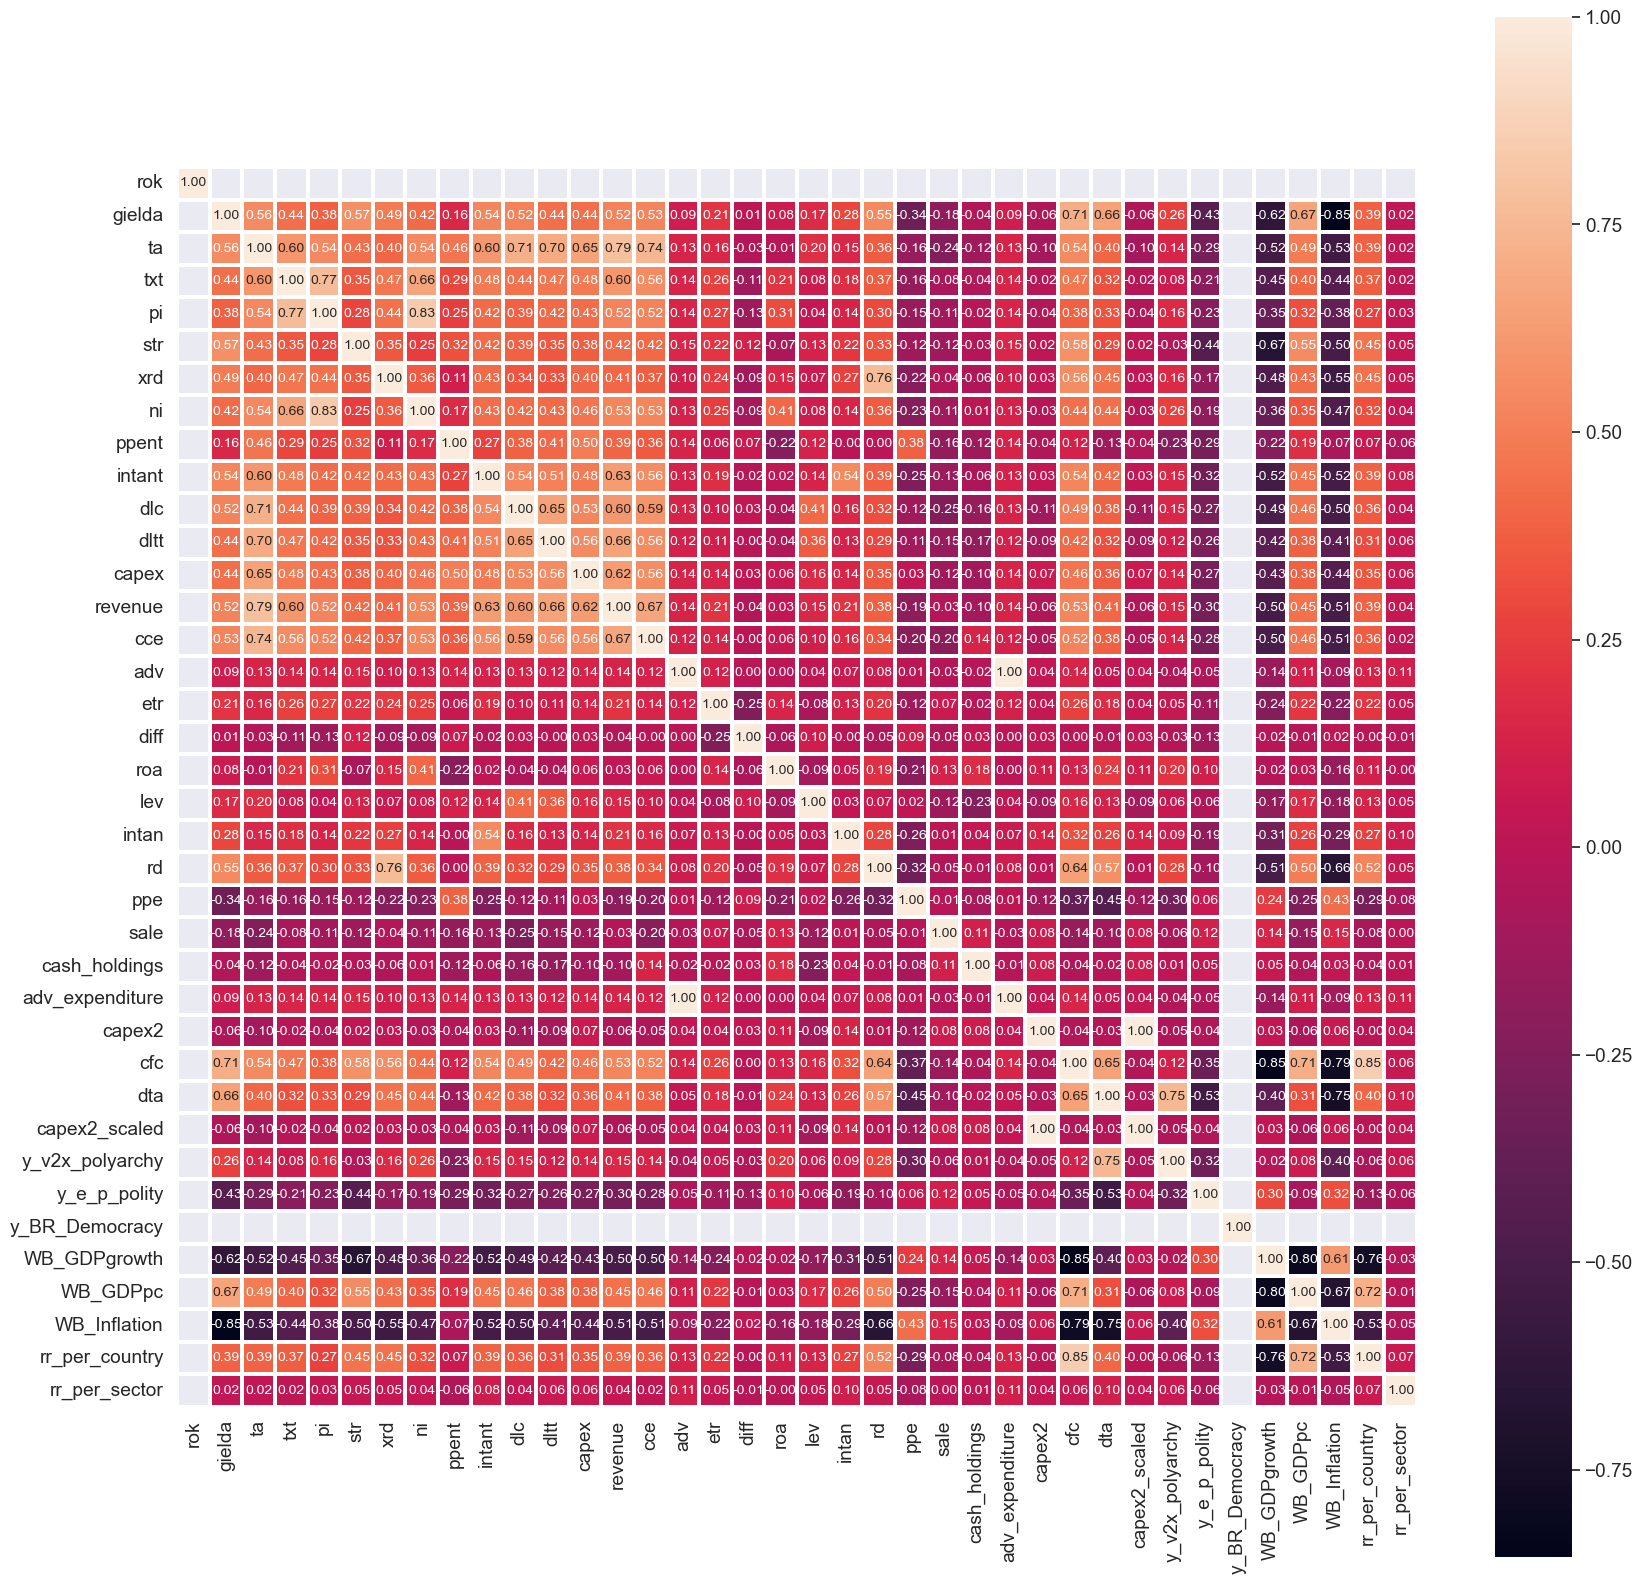

In [103]:
corr = df[con]
corr = df[df.rok == 2008].corr("kendall")
plt.figure(figsize=(20, 20))
sns.set(font_scale=1.25)
sns.heatmap(
    corr, linewidths=1.5, annot=True, square=True, fmt=".2f", annot_kws={"size": 10}
)
plt.show()

**Correlation plot - 2005**

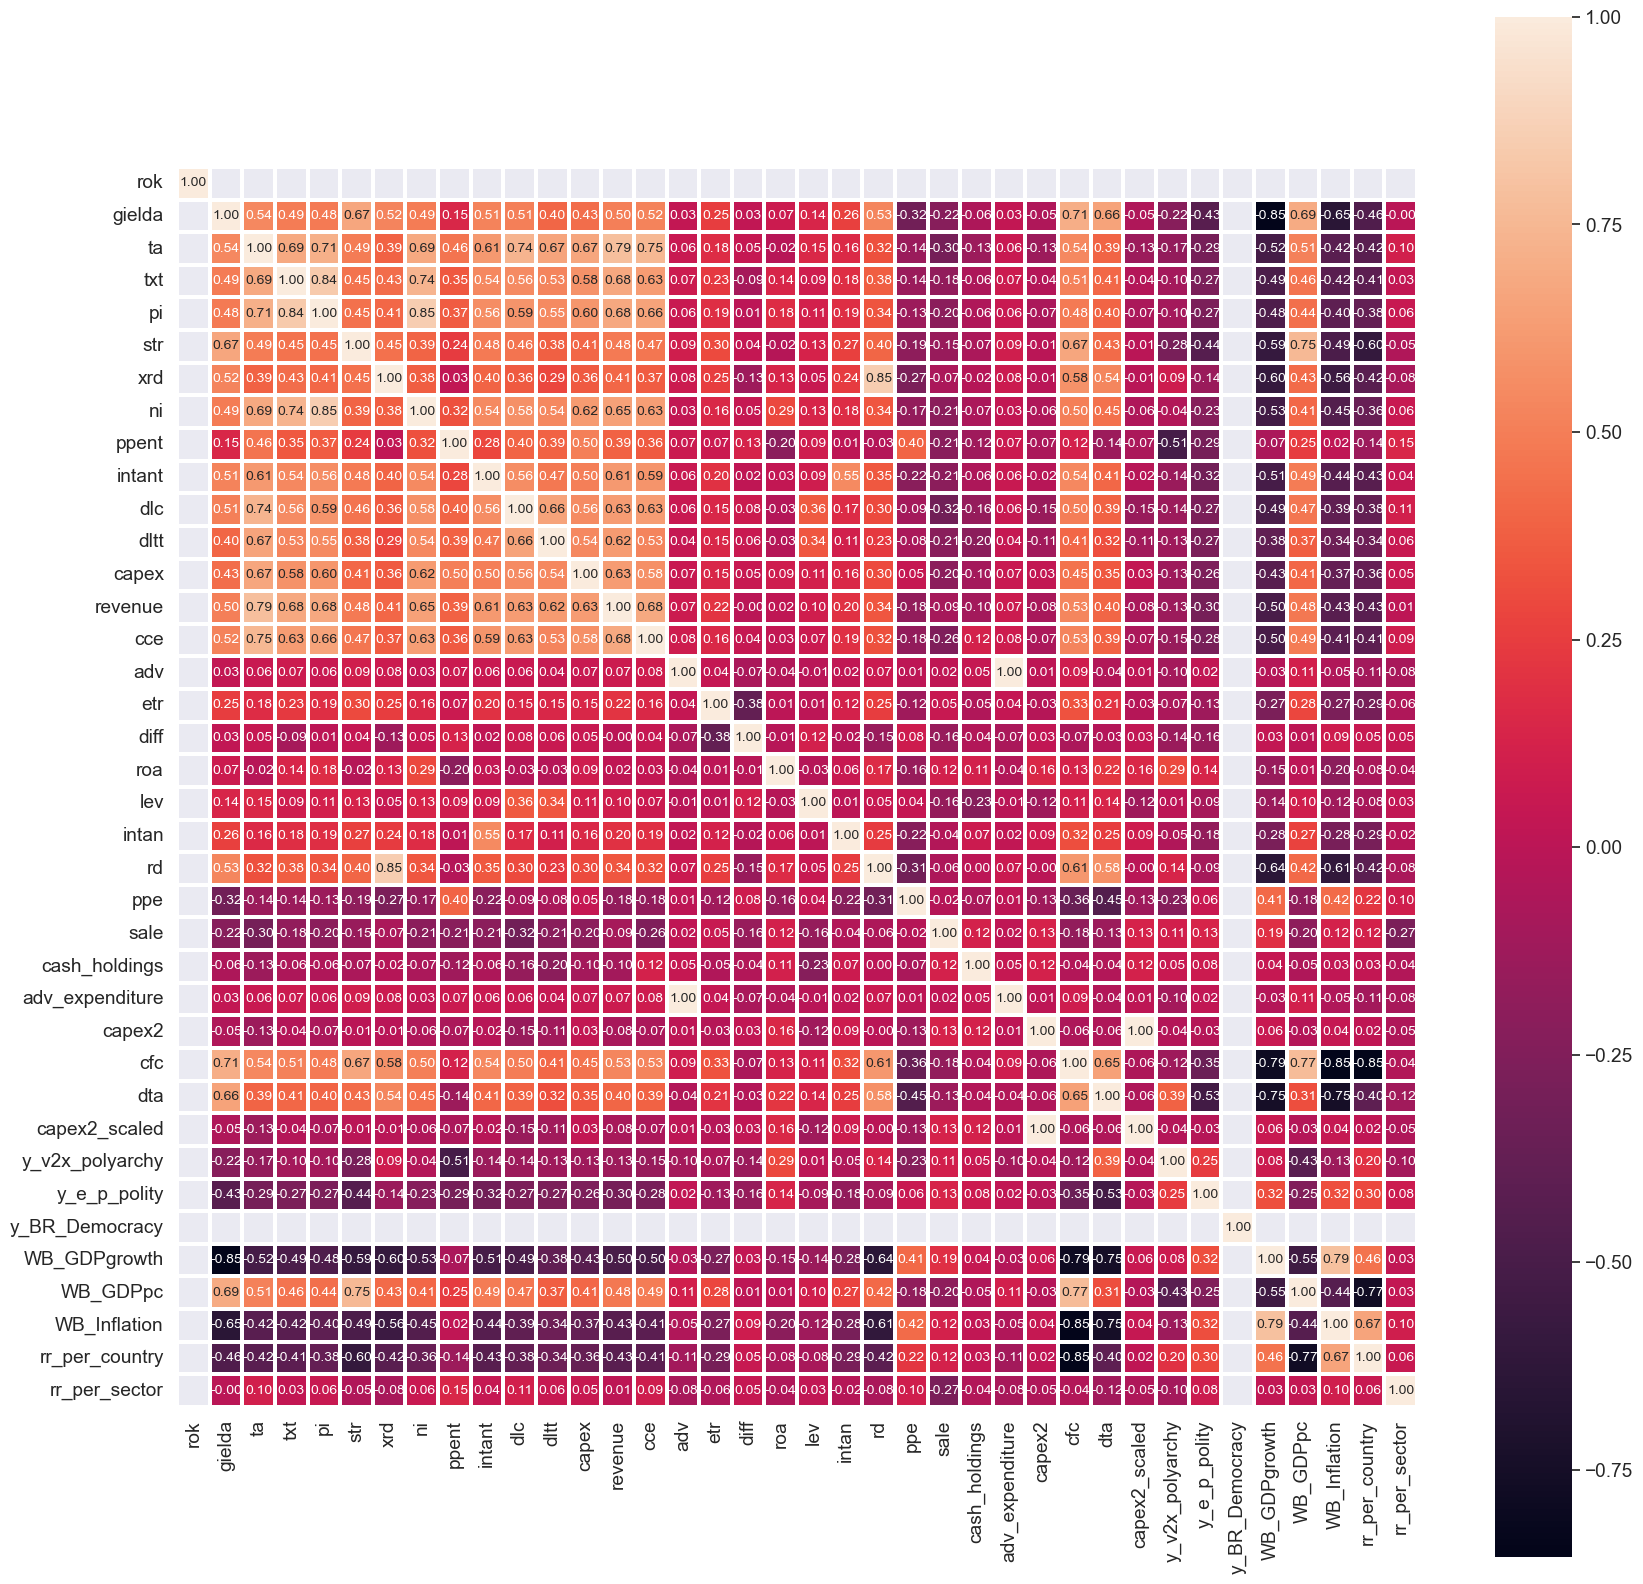

In [104]:
corr = df[con]
corr = df[df.rok == 2005].corr("kendall")
plt.figure(figsize=(20, 20))
sns.set(font_scale=1.25)
sns.heatmap(
    corr, linewidths=1.5, annot=True, square=True, fmt=".2f", annot_kws={"size": 10}
)
plt.show()